## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

LABELS = [
    "jalan_DR", "jalan_UR", "jalan_DL", "jalan_UL",
    "sapu_DR", "sapu_UR", "sapu_DL", "sapu_UL",
    "suspicious_DR", "suspicious_UR", "suspicious_DL", "suspicious_UL",
#     "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
    "idle"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/Direct/NoDoor/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(1794, 8, 36) (1794, 1) 295.26193 263.74173

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(13,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
training_iters = training_data_count *2048
# training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 4.812915, Accuracy = 0.125
PERFORMANCE ON TEST SET:             Batch Loss = 4.709615230560303, Accuracy = 0.10312151908874512
Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.246654, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 4.185491561889648, Accuracy = 0.19230769574642181
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 4.210457, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 4.080528736114502, Accuracy = 0.20568561553955078
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 4.088448, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 3.9906201362609863, Accuracy = 0.22240802645683289
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 3.813631, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 3.9513680934906006, Accuracy = 0.2001114785671234
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 3.809281, Accuracy = 0.234375
PERFORMA

Iter #23552:  Learning rate = 0.005000:   Batch Loss = 2.854120, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.9486470222473145, Accuracy = 0.38294315338134766
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 3.068082, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.8968091011047363, Accuracy = 0.39855071902275085
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 2.891968, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.903932809829712, Accuracy = 0.37792640924453735
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 2.808429, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.9110543727874756, Accuracy = 0.3952062427997589
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 2.871255, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.8279571533203125, Accuracy = 0.4080267548561096
Iter #26112:  Learning rate = 0.005000:   Batch Loss = 3.000817, Accuracy = 

Iter #46592:  Learning rate = 0.005000:   Batch Loss = 2.687582, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.6620373725891113, Accuracy = 0.4175027906894684
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.757542, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.5732507705688477, Accuracy = 0.4687848389148712
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 2.486572, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.5409998893737793, Accuracy = 0.47603121399879456
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 2.451833, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.5501623153686523, Accuracy = 0.4576365649700165
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 2.642618, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.547499656677246, Accuracy = 0.46711260080337524
Iter #49152:  Learning rate = 0.005000:   Batch Loss = 2.557302, Accuracy = 0

Iter #69632:  Learning rate = 0.005000:   Batch Loss = 2.356505, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3416078090667725, Accuracy = 0.5
Iter #70144:  Learning rate = 0.005000:   Batch Loss = 2.496338, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.349160671234131, Accuracy = 0.49554067850112915
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 2.418149, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3526713848114014, Accuracy = 0.5011148452758789
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 2.504604, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4161665439605713, Accuracy = 0.4687848389148712
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 2.488763, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.435274124145508, Accuracy = 0.4403567314147949
Iter #72192:  Learning rate = 0.005000:   Batch Loss = 2.373732, Accuracy = 0.46875
PERFORMA

PERFORMANCE ON TEST SET:             Batch Loss = 2.2534892559051514, Accuracy = 0.5306577682495117
Iter #93184:  Learning rate = 0.005000:   Batch Loss = 1.935818, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2299458980560303, Accuracy = 0.516165018081665
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 2.240481, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2556185722351074, Accuracy = 0.5105908513069153
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 2.145239, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2596497535705566, Accuracy = 0.49052396416664124
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 2.406788, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.235947608947754, Accuracy = 0.5156075954437256
Iter #95232:  Learning rate = 0.005000:   Batch Loss = 2.352958, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2389988899230957, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 2.242255449295044, Accuracy = 0.49554067850112915
Iter #116736:  Learning rate = 0.004800:   Batch Loss = 2.335019, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.2088048458099365, Accuracy = 0.5167223811149597
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 2.170161, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.200587272644043, Accuracy = 0.5178372263908386
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 2.009996, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.284823179244995, Accuracy = 0.47380155324935913
Iter #118272:  Learning rate = 0.004800:   Batch Loss = 2.252812, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.292539596557617, Accuracy = 0.4821627736091614
Iter #118784:  Learning rate = 0.004800:   Batch Loss = 2.261264, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.279324769973755, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 2.4671823978424072, Accuracy = 0.4264214038848877
Iter #139264:  Learning rate = 0.004800:   Batch Loss = 2.365737, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4284632205963135, Accuracy = 0.4453734755516052
Iter #139776:  Learning rate = 0.004800:   Batch Loss = 2.567465, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.435518980026245, Accuracy = 0.4158305525779724
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 2.676304, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.6419503688812256, Accuracy = 0.35730212926864624
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 2.342620, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.5439014434814453, Accuracy = 0.3851727843284607
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 2.421162, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.482574462890625, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 2.2364888191223145, Accuracy = 0.49275362491607666
Iter #163328:  Learning rate = 0.004800:   Batch Loss = 2.279251, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.244136333465576, Accuracy = 0.4648829400539398
Iter #163840:  Learning rate = 0.004800:   Batch Loss = 2.149172, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2485766410827637, Accuracy = 0.48272016644477844
Iter #164352:  Learning rate = 0.004800:   Batch Loss = 2.453402, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.225041151046753, Accuracy = 0.4843924045562744
Iter #164864:  Learning rate = 0.004800:   Batch Loss = 2.275915, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2528481483459473, Accuracy = 0.47491639852523804
Iter #165376:  Learning rate = 0.004800:   Batch Loss = 2.017309, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.251288890838623, Acc

Iter #186368:  Learning rate = 0.004800:   Batch Loss = 2.601159, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2090907096862793, Accuracy = 0.49442586302757263
Iter #186880:  Learning rate = 0.004800:   Batch Loss = 2.108553, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1687958240509033, Accuracy = 0.502229630947113
Iter #187392:  Learning rate = 0.004800:   Batch Loss = 2.160595, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1663432121276855, Accuracy = 0.5011148452758789
Iter #187904:  Learning rate = 0.004800:   Batch Loss = 2.110764, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.20819354057312, Accuracy = 0.4687848389148712
Iter #188416:  Learning rate = 0.004800:   Batch Loss = 2.360847, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1916441917419434, Accuracy = 0.4832775890827179
Iter #188928:  Learning rate = 0.004800:   Batch Loss = 2.061010, Accuracy =

Iter #209408:  Learning rate = 0.004608:   Batch Loss = 2.401882, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.236024856567383, Accuracy = 0.4726867377758026
Iter #209920:  Learning rate = 0.004608:   Batch Loss = 2.294208, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.210174560546875, Accuracy = 0.46934226155281067
Iter #210432:  Learning rate = 0.004608:   Batch Loss = 2.180901, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1948256492614746, Accuracy = 0.4816053509712219
Iter #210944:  Learning rate = 0.004608:   Batch Loss = 2.358902, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2281599044799805, Accuracy = 0.46989965438842773
Iter #211456:  Learning rate = 0.004608:   Batch Loss = 2.260755, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.2190656661987305, Accuracy = 0.46042364835739136
Iter #211968:  Learning rate = 0.004608:   Batch Loss = 2.135588, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 2.183753728866577, Accuracy = 0.48885172605514526
Iter #232960:  Learning rate = 0.004608:   Batch Loss = 2.173492, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.154188632965088, Accuracy = 0.47101449966430664
Iter #233472:  Learning rate = 0.004608:   Batch Loss = 2.226060, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1498427391052246, Accuracy = 0.46989965438842773
Iter #233984:  Learning rate = 0.004608:   Batch Loss = 2.210119, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1730899810791016, Accuracy = 0.47826087474823
Iter #234496:  Learning rate = 0.004608:   Batch Loss = 2.144450, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1643292903900146, Accuracy = 0.4615384638309479
Iter #235008:  Learning rate = 0.004608:   Batch Loss = 2.218356, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.063603639602661, Accurac

Iter #255488:  Learning rate = 0.004608:   Batch Loss = 1.858804, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9552414417266846, Accuracy = 0.5507246255874634
Iter #256000:  Learning rate = 0.004608:   Batch Loss = 1.868015, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9419642686843872, Accuracy = 0.5596432685852051
Iter #256512:  Learning rate = 0.004608:   Batch Loss = 2.005770, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9552335739135742, Accuracy = 0.5535116791725159
Iter #257024:  Learning rate = 0.004608:   Batch Loss = 1.906023, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0355336666107178, Accuracy = 0.5462653040885925
Iter #257536:  Learning rate = 0.004608:   Batch Loss = 1.979472, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0330309867858887, Accuracy = 0.5172798037528992
Iter #258048:  Learning rate = 0.004608:   Batch Loss = 2.190749, Accuracy 

Iter #279040:  Learning rate = 0.004608:   Batch Loss = 1.865832, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9325692653656006, Accuracy = 0.5797101259231567
Iter #279552:  Learning rate = 0.004608:   Batch Loss = 1.964190, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9342833757400513, Accuracy = 0.568561851978302
Iter #280064:  Learning rate = 0.004608:   Batch Loss = 1.608865, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.935051441192627, Accuracy = 0.5680044889450073
Iter #280576:  Learning rate = 0.004608:   Batch Loss = 2.058957, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9139811992645264, Accuracy = 0.5797101259231567
Iter #281088:  Learning rate = 0.004608:   Batch Loss = 2.014929, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.951648473739624, Accuracy = 0.5568562150001526
Iter #281600:  Learning rate = 0.004608:   Batch Loss = 1.930481, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 2.0300846099853516, Accuracy = 0.5501672029495239
Iter #303104:  Learning rate = 0.004424:   Batch Loss = 1.934113, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0397067070007324, Accuracy = 0.5406911969184875
Iter #303616:  Learning rate = 0.004424:   Batch Loss = 2.203948, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0929486751556396, Accuracy = 0.5128205418586731
Iter #304128:  Learning rate = 0.004424:   Batch Loss = 2.174616, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1003918647766113, Accuracy = 0.5133779048919678
Iter #304640:  Learning rate = 0.004424:   Batch Loss = 2.137430, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.0817644596099854, Accuracy = 0.5061315298080444
Iter #305152:  Learning rate = 0.004424:   Batch Loss = 2.165016, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0438578128814697, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.9580869674682617, Accuracy = 0.5462653040885925
Iter #326144:  Learning rate = 0.004424:   Batch Loss = 1.836522, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9557430744171143, Accuracy = 0.5384615659713745
Iter #326656:  Learning rate = 0.004424:   Batch Loss = 2.053490, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9288527965545654, Accuracy = 0.5635451674461365
Iter #327168:  Learning rate = 0.004424:   Batch Loss = 1.958474, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9345624446868896, Accuracy = 0.5590858459472656
Iter #327680:  Learning rate = 0.004424:   Batch Loss = 1.864802, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0649094581604004, Accuracy = 0.519509494304657
Iter #328192:  Learning rate = 0.004424:   Batch Loss = 2.158645, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0444345474243164, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 2.206287145614624, Accuracy = 0.4754737913608551
Iter #349184:  Learning rate = 0.004424:   Batch Loss = 2.230322, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.150477409362793, Accuracy = 0.4715718924999237
Iter #349696:  Learning rate = 0.004424:   Batch Loss = 2.259542, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.075725793838501, Accuracy = 0.5144927501678467
Iter #350208:  Learning rate = 0.004424:   Batch Loss = 2.023402, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0698983669281006, Accuracy = 0.4910813868045807
Iter #350720:  Learning rate = 0.004424:   Batch Loss = 2.039546, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.0266716480255127, Accuracy = 0.5228539705276489
Iter #351232:  Learning rate = 0.004424:   Batch Loss = 1.969262, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0122804641723633, Accuracy = 0.549

Iter #372224:  Learning rate = 0.004424:   Batch Loss = 2.017273, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9453186988830566, Accuracy = 0.5484949946403503
Iter #372736:  Learning rate = 0.004424:   Batch Loss = 1.932899, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9162812232971191, Accuracy = 0.5602006912231445
Iter #373248:  Learning rate = 0.004424:   Batch Loss = 1.935734, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.898486614227295, Accuracy = 0.5551839470863342
Iter #373760:  Learning rate = 0.004424:   Batch Loss = 2.010871, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9146034717559814, Accuracy = 0.5635451674461365
Iter #374272:  Learning rate = 0.004424:   Batch Loss = 1.888619, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.984036922454834, Accuracy = 0.5284280776977539
Iter #374784:  Learning rate = 0.004424:   Batch Loss = 2.091847, Accuracy 

Iter #395264:  Learning rate = 0.004424:   Batch Loss = 1.829773, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9192407131195068, Accuracy = 0.5562987923622131
Iter #395776:  Learning rate = 0.004424:   Batch Loss = 1.827322, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9305824041366577, Accuracy = 0.5462653040885925
Iter #396288:  Learning rate = 0.004424:   Batch Loss = 2.035354, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9913249015808105, Accuracy = 0.5239687561988831
Iter #396800:  Learning rate = 0.004424:   Batch Loss = 1.922148, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.863826036453247, Accuracy = 0.5680044889450073
Iter #397312:  Learning rate = 0.004424:   Batch Loss = 1.848829, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8455740213394165, Accuracy = 0.5969899892807007
Iter #397824:  Learning rate = 0.004424:   Batch Loss = 1.738892, Accuracy = 0.6

PERFORMANCE ON TEST SET:             Batch Loss = 1.8278658390045166, Accuracy = 0.6014492511749268
Iter #419328:  Learning rate = 0.004247:   Batch Loss = 1.751228, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8269656896591187, Accuracy = 0.5992196202278137
Iter #419840:  Learning rate = 0.004247:   Batch Loss = 2.042994, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8907053470611572, Accuracy = 0.5641025900840759
Iter #420352:  Learning rate = 0.004247:   Batch Loss = 1.912423, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.823573112487793, Accuracy = 0.5841694474220276
Iter #420864:  Learning rate = 0.004247:   Batch Loss = 2.089725, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.880075216293335, Accuracy = 0.5841694474220276
Iter #421376:  Learning rate = 0.004247:   Batch Loss = 2.099187, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9645838737487793, Acc

Iter #442368:  Learning rate = 0.004247:   Batch Loss = 1.679367, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7120118141174316, Accuracy = 0.6198439002037048
Iter #442880:  Learning rate = 0.004247:   Batch Loss = 1.681527, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7050844430923462, Accuracy = 0.631549596786499
Iter #443392:  Learning rate = 0.004247:   Batch Loss = 1.809622, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7134097814559937, Accuracy = 0.6204013228416443
Iter #443904:  Learning rate = 0.004247:   Batch Loss = 1.888475, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7121156454086304, Accuracy = 0.6276476979255676
Iter #444416:  Learning rate = 0.004247:   Batch Loss = 1.715122, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7579941749572754, Accuracy = 0.6070234179496765
Iter #444928:  Learning rate = 0.004247:   Batch Loss = 1.707327, Accurac

Iter #466432:  Learning rate = 0.004247:   Batch Loss = 2.026196, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.862333059310913, Accuracy = 0.5780379176139832
Iter #466944:  Learning rate = 0.004247:   Batch Loss = 1.995386, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8749773502349854, Accuracy = 0.5774804949760437
Iter #467456:  Learning rate = 0.004247:   Batch Loss = 1.687020, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9116854667663574, Accuracy = 0.5557413697242737
Iter #467968:  Learning rate = 0.004247:   Batch Loss = 1.950298, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0633208751678467, Accuracy = 0.5078037977218628
Iter #468480:  Learning rate = 0.004247:   Batch Loss = 2.006321, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0905845165252686, Accuracy = 0.48494982719421387
Iter #468992:  Learning rate = 0.004247:   Batch Loss = 2.327167, Accuracy = 0

Iter #488960:  Learning rate = 0.004247:   Batch Loss = 1.823880, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7681879997253418, Accuracy = 0.6125975251197815
Iter #489472:  Learning rate = 0.004247:   Batch Loss = 1.742342, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7274072170257568, Accuracy = 0.6343366503715515
Iter #489984:  Learning rate = 0.004247:   Batch Loss = 1.748970, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7635234594345093, Accuracy = 0.613154947757721
Iter #490496:  Learning rate = 0.004247:   Batch Loss = 1.702862, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7206171751022339, Accuracy = 0.629319965839386
Iter #491008:  Learning rate = 0.004247:   Batch Loss = 1.702358, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7228584289550781, Accuracy = 0.6326644420623779
Iter #491520:  Learning rate = 0.004247:   Batch Loss = 1.632409, Accuracy 

Iter #512000:  Learning rate = 0.004077:   Batch Loss = 1.587683, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7413172721862793, Accuracy = 0.5964325666427612
Iter #512512:  Learning rate = 0.004077:   Batch Loss = 1.792602, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7291115522384644, Accuracy = 0.6070234179496765
Iter #513024:  Learning rate = 0.004077:   Batch Loss = 1.699934, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7046552896499634, Accuracy = 0.6064659953117371
Iter #513536:  Learning rate = 0.004077:   Batch Loss = 1.575939, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6878875494003296, Accuracy = 0.6220735907554626
Iter #514048:  Learning rate = 0.004077:   Batch Loss = 1.747688, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6581196784973145, Accuracy = 0.6371237635612488
Iter #514560:  Learning rate = 0.004077:   Batch Loss = 1.494844, Accur

Iter #535040:  Learning rate = 0.004077:   Batch Loss = 1.769772, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.711632490158081, Accuracy = 0.6270902752876282
Iter #535552:  Learning rate = 0.004077:   Batch Loss = 1.779132, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.727612853050232, Accuracy = 0.6215161681175232
Iter #536064:  Learning rate = 0.004077:   Batch Loss = 1.917084, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.741873860359192, Accuracy = 0.6103678941726685
Iter #536576:  Learning rate = 0.004077:   Batch Loss = 1.752889, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.730621576309204, Accuracy = 0.6092530488967896
Iter #537088:  Learning rate = 0.004077:   Batch Loss = 1.683329, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7089252471923828, Accuracy = 0.6120401620864868
Iter #537600:  Learning rate = 0.004077:   Batch Loss = 1.798985, Accuracy = 0.5781

Iter #558080:  Learning rate = 0.004077:   Batch Loss = 1.573005, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6655038595199585, Accuracy = 0.6426978707313538
Iter #558592:  Learning rate = 0.004077:   Batch Loss = 1.797344, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6793112754821777, Accuracy = 0.6309921741485596
Iter #559104:  Learning rate = 0.004077:   Batch Loss = 1.617900, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6761474609375, Accuracy = 0.6326644420623779
Iter #559616:  Learning rate = 0.004077:   Batch Loss = 1.766283, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6685932874679565, Accuracy = 0.6309921741485596
Iter #560128:  Learning rate = 0.004077:   Batch Loss = 1.791000, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7435851097106934, Accuracy = 0.6092530488967896
Iter #560640:  Learning rate = 0.004077:   Batch Loss = 1.671969, Accuracy = 

Iter #581120:  Learning rate = 0.004077:   Batch Loss = 1.315139, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5879958868026733, Accuracy = 0.6655518412590027
Iter #581632:  Learning rate = 0.004077:   Batch Loss = 1.701424, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.681730031967163, Accuracy = 0.6270902752876282
Iter #582144:  Learning rate = 0.004077:   Batch Loss = 1.535753, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5983045101165771, Accuracy = 0.6516165137290955
Iter #582656:  Learning rate = 0.004077:   Batch Loss = 1.732801, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5852322578430176, Accuracy = 0.6616499423980713
Iter #583168:  Learning rate = 0.004077:   Batch Loss = 1.718746, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6166739463806152, Accuracy = 0.6505016684532166
Iter #583680:  Learning rate = 0.004077:   Batch Loss = 1.683010, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.7907655239105225, Accuracy = 0.5730211734771729
Iter #604160:  Learning rate = 0.003914:   Batch Loss = 1.831908, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7647895812988281, Accuracy = 0.6031215190887451
Iter #604672:  Learning rate = 0.003914:   Batch Loss = 1.741363, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.721837043762207, Accuracy = 0.6220735907554626
Iter #605184:  Learning rate = 0.003914:   Batch Loss = 1.668763, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7148261070251465, Accuracy = 0.6321070194244385
Iter #605696:  Learning rate = 0.003914:   Batch Loss = 1.925146, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6896278858184814, Accuracy = 0.6237457990646362
Iter #606208:  Learning rate = 0.003914:   Batch Loss = 1.854079, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6667348146438599, Accura

Iter #627200:  Learning rate = 0.003914:   Batch Loss = 1.484086, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6067495346069336, Accuracy = 0.6560758352279663
Iter #627712:  Learning rate = 0.003914:   Batch Loss = 1.532028, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.5828981399536133, Accuracy = 0.6661092638969421
Iter #628224:  Learning rate = 0.003914:   Batch Loss = 1.566999, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.580611228942871, Accuracy = 0.6700111627578735
Iter #628736:  Learning rate = 0.003914:   Batch Loss = 1.478175, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.554456353187561, Accuracy = 0.6806020140647888
Iter #629248:  Learning rate = 0.003914:   Batch Loss = 1.563225, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.581746220588684, Accuracy = 0.6694537401199341
Iter #629760:  Learning rate = 0.003914:   Batch Loss = 1.640496, Accuracy = 0.671

Iter #650240:  Learning rate = 0.003914:   Batch Loss = 1.936683, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6457853317260742, Accuracy = 0.6404682397842407
Iter #650752:  Learning rate = 0.003914:   Batch Loss = 1.614889, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6240999698638916, Accuracy = 0.6443701386451721
Iter #651264:  Learning rate = 0.003914:   Batch Loss = 1.961465, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6437008380889893, Accuracy = 0.6360089182853699
Iter #651776:  Learning rate = 0.003914:   Batch Loss = 1.613958, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7099226713180542, Accuracy = 0.6047937273979187
Iter #652288:  Learning rate = 0.003914:   Batch Loss = 1.769794, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.72635817527771, Accuracy = 0.6053511500358582
Iter #652800:  Learning rate = 0.003914:   Batch Loss = 1.623054, Accuracy = 0.625


PERFORMANCE ON TEST SET:             Batch Loss = 1.5562584400177002, Accuracy = 0.6744704842567444
Iter #673792:  Learning rate = 0.003914:   Batch Loss = 1.521247, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5419819355010986, Accuracy = 0.6833890676498413
Iter #674304:  Learning rate = 0.003914:   Batch Loss = 1.662982, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5719866752624512, Accuracy = 0.6638795733451843
Iter #674816:  Learning rate = 0.003914:   Batch Loss = 1.609001, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.537414312362671, Accuracy = 0.672798216342926
Iter #675328:  Learning rate = 0.003914:   Batch Loss = 1.377191, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5004067420959473, Accuracy = 0.695652186870575
Iter #675840:  Learning rate = 0.003914:   Batch Loss = 1.482692, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5114929676055908, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.5452876091003418, Accuracy = 0.6722407937049866
Iter #696320:  Learning rate = 0.003914:   Batch Loss = 1.667655, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5592041015625, Accuracy = 0.6638795733451843
Iter #696832:  Learning rate = 0.003914:   Batch Loss = 1.521743, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6179144382476807, Accuracy = 0.6527312994003296
Iter #697344:  Learning rate = 0.003914:   Batch Loss = 1.786263, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.618927240371704, Accuracy = 0.6265329122543335
Iter #697856:  Learning rate = 0.003914:   Batch Loss = 1.500263, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.651807427406311, Accuracy = 0.6209587454795837
Iter #698368:  Learning rate = 0.003914:   Batch Loss = 1.827770, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6272532939910889, Accuracy

Iter #719360:  Learning rate = 0.003757:   Batch Loss = 1.940803, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8149977922439575, Accuracy = 0.5674470663070679
Iter #719872:  Learning rate = 0.003757:   Batch Loss = 1.952907, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8432502746582031, Accuracy = 0.5484949946403503
Iter #720384:  Learning rate = 0.003757:   Batch Loss = 1.832628, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8149604797363281, Accuracy = 0.5696766972541809
Iter #720896:  Learning rate = 0.003757:   Batch Loss = 1.619774, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7446550130844116, Accuracy = 0.5891861915588379
Iter #721408:  Learning rate = 0.003757:   Batch Loss = 1.666070, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7750407457351685, Accuracy = 0.582497239112854
Iter #721920:  Learning rate = 0.003757:   Batch Loss = 1.838505, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.566899299621582, Accuracy = 0.6644369959831238
Iter #742912:  Learning rate = 0.003757:   Batch Loss = 1.609654, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6075998544692993, Accuracy = 0.6438127160072327
Iter #743424:  Learning rate = 0.003757:   Batch Loss = 1.632173, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6110906600952148, Accuracy = 0.6371237635612488
Iter #743936:  Learning rate = 0.003757:   Batch Loss = 1.712792, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5960321426391602, Accuracy = 0.6248606443405151
Iter #744448:  Learning rate = 0.003757:   Batch Loss = 1.455939, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5688542127609253, Accuracy = 0.6571906208992004
Iter #744960:  Learning rate = 0.003757:   Batch Loss = 1.573438, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5908570289611816, Accur

Iter #765952:  Learning rate = 0.003757:   Batch Loss = 1.689887, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7854869365692139, Accuracy = 0.6047937273979187
Iter #766464:  Learning rate = 0.003757:   Batch Loss = 1.697186, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7548868656158447, Accuracy = 0.5953177213668823
Iter #766976:  Learning rate = 0.003757:   Batch Loss = 1.737387, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7227141857147217, Accuracy = 0.6137123703956604
Iter #767488:  Learning rate = 0.003757:   Batch Loss = 1.734460, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7123727798461914, Accuracy = 0.6176142692565918
Iter #768000:  Learning rate = 0.003757:   Batch Loss = 1.740387, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6849234104156494, Accuracy = 0.6354514956474304
Iter #768512:  Learning rate = 0.003757:   Batch Loss = 1.584835, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.5991883277893066, Accuracy = 0.6666666865348816
Iter #788992:  Learning rate = 0.003757:   Batch Loss = 1.699941, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5692408084869385, Accuracy = 0.670568585395813
Iter #789504:  Learning rate = 0.003757:   Batch Loss = 1.387255, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5705201625823975, Accuracy = 0.6722407937049866
Iter #790016:  Learning rate = 0.003757:   Batch Loss = 1.549461, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5817385911941528, Accuracy = 0.667224109172821
Iter #790528:  Learning rate = 0.003757:   Batch Loss = 1.597681, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5631752014160156, Accuracy = 0.6711259484291077
Iter #791040:  Learning rate = 0.003757:   Batch Loss = 1.709686, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5869202613830566, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.6013203859329224, Accuracy = 0.654403567314148
Iter #812544:  Learning rate = 0.003607:   Batch Loss = 1.758064, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6169235706329346, Accuracy = 0.6571906208992004
Iter #813056:  Learning rate = 0.003607:   Batch Loss = 1.595793, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.613156795501709, Accuracy = 0.6449275612831116
Iter #813568:  Learning rate = 0.003607:   Batch Loss = 1.865301, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6138770580291748, Accuracy = 0.6599776744842529
Iter #814080:  Learning rate = 0.003607:   Batch Loss = 1.592686, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5901066064834595, Accuracy = 0.6577480435371399
Iter #814592:  Learning rate = 0.003607:   Batch Loss = 1.547359, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5833723545074463, Accurac

Iter #835072:  Learning rate = 0.003607:   Batch Loss = 1.716996, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6099382638931274, Accuracy = 0.6387959718704224
Iter #835584:  Learning rate = 0.003607:   Batch Loss = 1.613929, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5688323974609375, Accuracy = 0.6499442458152771
Iter #836096:  Learning rate = 0.003607:   Batch Loss = 1.471275, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5725741386413574, Accuracy = 0.6555184125900269
Iter #836608:  Learning rate = 0.003607:   Batch Loss = 1.493291, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.541935920715332, Accuracy = 0.6677814722061157
Iter #837120:  Learning rate = 0.003607:   Batch Loss = 1.717682, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.572568416595459, Accuracy = 0.6666666865348816
Iter #837632:  Learning rate = 0.003607:   Batch Loss = 1.655121, Accuracy

Iter #858624:  Learning rate = 0.003607:   Batch Loss = 1.596312, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5586035251617432, Accuracy = 0.6700111627578735
Iter #859136:  Learning rate = 0.003607:   Batch Loss = 1.458303, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5216107368469238, Accuracy = 0.6850613355636597
Iter #859648:  Learning rate = 0.003607:   Batch Loss = 1.459671, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5327019691467285, Accuracy = 0.6716833710670471
Iter #860160:  Learning rate = 0.003607:   Batch Loss = 1.635116, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5628597736358643, Accuracy = 0.6627647876739502
Iter #860672:  Learning rate = 0.003607:   Batch Loss = 1.509556, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5634042024612427, Accuracy = 0.6694537401199341
Iter #861184:  Learning rate = 0.003607:   Batch Loss = 1.368876, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 1.6016942262649536, Accuracy = 0.6521739363670349
Iter #881664:  Learning rate = 0.003607:   Batch Loss = 1.637953, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.566373348236084, Accuracy = 0.6605350971221924
Iter #882176:  Learning rate = 0.003607:   Batch Loss = 1.509140, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5317797660827637, Accuracy = 0.6683388948440552
Iter #882688:  Learning rate = 0.003607:   Batch Loss = 1.795690, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4927704334259033, Accuracy = 0.692307710647583
Iter #883200:  Learning rate = 0.003607:   Batch Loss = 1.277042, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4774084091186523, Accuracy = 0.7051281929016113
Iter #883712:  Learning rate = 0.003607:   Batch Loss = 1.319661, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4886685609817505, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.5077638626098633, Accuracy = 0.6833890676498413
Iter #904192:  Learning rate = 0.003463:   Batch Loss = 1.408718, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4987658262252808, Accuracy = 0.678372323513031
Iter #904704:  Learning rate = 0.003463:   Batch Loss = 1.341971, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.459924578666687, Accuracy = 0.7056856155395508
Iter #905216:  Learning rate = 0.003463:   Batch Loss = 1.502344, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4579460620880127, Accuracy = 0.7012262940406799
Iter #905728:  Learning rate = 0.003463:   Batch Loss = 1.565431, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.47291100025177, Accuracy = 0.7045707702636719
Iter #906240:  Learning rate = 0.003463:   Batch Loss = 1.394071, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4915790557861328, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 1.4866193532943726, Accuracy = 0.6895205974578857
Iter #927744:  Learning rate = 0.003463:   Batch Loss = 1.556281, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4901237487792969, Accuracy = 0.6800445914268494
Iter #928256:  Learning rate = 0.003463:   Batch Loss = 1.399279, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.478655219078064, Accuracy = 0.7001115083694458
Iter #928768:  Learning rate = 0.003463:   Batch Loss = 1.551118, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5078566074371338, Accuracy = 0.6884058117866516
Iter #929280:  Learning rate = 0.003463:   Batch Loss = 1.353041, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4958158731460571, Accuracy = 0.6839464902877808
Iter #929792:  Learning rate = 0.003463:   Batch Loss = 1.484840, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.461456298828125, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.5509858131408691, Accuracy = 0.6655518412590027
Iter #950784:  Learning rate = 0.003463:   Batch Loss = 1.522607, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5476922988891602, Accuracy = 0.6610925197601318
Iter #951296:  Learning rate = 0.003463:   Batch Loss = 1.754101, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5713692903518677, Accuracy = 0.6527312994003296
Iter #951808:  Learning rate = 0.003463:   Batch Loss = 1.350259, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.6036927700042725, Accuracy = 0.6376811861991882
Iter #952320:  Learning rate = 0.003463:   Batch Loss = 1.415622, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5481419563293457, Accuracy = 0.6599776744842529
Iter #952832:  Learning rate = 0.003463:   Batch Loss = 1.337594, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5094568729400635, Accura

Iter #973824:  Learning rate = 0.003463:   Batch Loss = 1.537723, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4700310230255127, Accuracy = 0.6856187582015991
Iter #974336:  Learning rate = 0.003463:   Batch Loss = 1.578865, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4610683917999268, Accuracy = 0.6895205974578857
Iter #974848:  Learning rate = 0.003463:   Batch Loss = 1.642764, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4826421737670898, Accuracy = 0.6878483891487122
Iter #975360:  Learning rate = 0.003463:   Batch Loss = 1.331539, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5472230911254883, Accuracy = 0.6649944186210632
Iter #975872:  Learning rate = 0.003463:   Batch Loss = 1.468508, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5558096170425415, Accuracy = 0.6638795733451843
Iter #976384:  Learning rate = 0.003463:   Batch Loss = 1.508564, Accurac

Iter #997376:  Learning rate = 0.003463:   Batch Loss = 1.326348, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3748421669006348, Accuracy = 0.74470454454422
Iter #997888:  Learning rate = 0.003463:   Batch Loss = 1.502162, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.362105369567871, Accuracy = 0.7424749135971069
Iter #998400:  Learning rate = 0.003463:   Batch Loss = 1.246270, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4226295948028564, Accuracy = 0.7218506336212158
Iter #998912:  Learning rate = 0.003463:   Batch Loss = 1.532281, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.428417444229126, Accuracy = 0.7012262940406799
Iter #999424:  Learning rate = 0.003463:   Batch Loss = 1.483667, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.427000880241394, Accuracy = 0.7090300917625427
Iter #999936:  Learning rate = 0.003463:   Batch Loss = 1.358298, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.4608131647109985, Accuracy = 0.6811594367027283
Iter #1021440:  Learning rate = 0.003324:   Batch Loss = 1.367321, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4220843315124512, Accuracy = 0.6928651332855225
Iter #1021952:  Learning rate = 0.003324:   Batch Loss = 1.458816, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3993239402770996, Accuracy = 0.7162764668464661
Iter #1022464:  Learning rate = 0.003324:   Batch Loss = 1.392098, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.387863039970398, Accuracy = 0.7212932109832764
Iter #1022976:  Learning rate = 0.003324:   Batch Loss = 1.357479, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3726320266723633, Accuracy = 0.7235228419303894
Iter #1023488:  Learning rate = 0.003324:   Batch Loss = 1.599979, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.369990587234497, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.3054581880569458, Accuracy = 0.7530657649040222
Iter #1044480:  Learning rate = 0.003324:   Batch Loss = 1.380349, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3051460981369019, Accuracy = 0.7525083422660828
Iter #1044992:  Learning rate = 0.003324:   Batch Loss = 1.431646, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3005321025848389, Accuracy = 0.7530657649040222
Iter #1045504:  Learning rate = 0.003324:   Batch Loss = 1.472728, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3102213144302368, Accuracy = 0.7502787113189697
Iter #1046016:  Learning rate = 0.003324:   Batch Loss = 1.278438, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3303114175796509, Accuracy = 0.7279821634292603
Iter #1046528:  Learning rate = 0.003324:   Batch Loss = 1.368408, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3857855796813965,

Iter #1067008:  Learning rate = 0.003324:   Batch Loss = 1.325621, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3030123710632324, Accuracy = 0.764214038848877
Iter #1067520:  Learning rate = 0.003324:   Batch Loss = 1.264560, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3359310626983643, Accuracy = 0.7402452826499939
Iter #1068032:  Learning rate = 0.003324:   Batch Loss = 1.408862, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.349241018295288, Accuracy = 0.7402452826499939
Iter #1068544:  Learning rate = 0.003324:   Batch Loss = 1.321097, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3629040718078613, Accuracy = 0.72296541929245
Iter #1069056:  Learning rate = 0.003324:   Batch Loss = 1.287541, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3529181480407715, Accuracy = 0.7218506336212158
Iter #1069568:  Learning rate = 0.003324:   Batch Loss = 1.522846, Accur

Iter #1090048:  Learning rate = 0.003324:   Batch Loss = 1.424102, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5171525478363037, Accuracy = 0.6811594367027283
Iter #1090560:  Learning rate = 0.003324:   Batch Loss = 1.437653, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5388829708099365, Accuracy = 0.6716833710670471
Iter #1091072:  Learning rate = 0.003324:   Batch Loss = 1.769684, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.566583275794983, Accuracy = 0.6655518412590027
Iter #1091584:  Learning rate = 0.003324:   Batch Loss = 1.590609, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.538299322128296, Accuracy = 0.6688963174819946
Iter #1092096:  Learning rate = 0.003324:   Batch Loss = 1.635402, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5739389657974243, Accuracy = 0.6605350971221924
Iter #1092608:  Learning rate = 0.003324:   Batch Loss = 1.551210, Acc

Iter #1113600:  Learning rate = 0.003191:   Batch Loss = 1.444754, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.430418848991394, Accuracy = 0.7051281929016113
Iter #1114112:  Learning rate = 0.003191:   Batch Loss = 1.502662, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.424384355545044, Accuracy = 0.7168338894844055
Iter #1114624:  Learning rate = 0.003191:   Batch Loss = 1.347582, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.378490686416626, Accuracy = 0.7374581694602966
Iter #1115136:  Learning rate = 0.003191:   Batch Loss = 1.245870, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3807839155197144, Accuracy = 0.7352285385131836
Iter #1115648:  Learning rate = 0.003191:   Batch Loss = 1.165918, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4269124269485474, Accuracy = 0.7101449370384216
Iter #1116160:  Learning rate = 0.003191:   Batch Loss = 1.356495, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.5910542011260986, Accuracy = 0.6415830254554749
Iter #1136640:  Learning rate = 0.003191:   Batch Loss = 1.570973, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6070104837417603, Accuracy = 0.6493868231773376
Iter #1137152:  Learning rate = 0.003191:   Batch Loss = 1.411416, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5490405559539795, Accuracy = 0.6694537401199341
Iter #1137664:  Learning rate = 0.003191:   Batch Loss = 1.793398, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.561889886856079, Accuracy = 0.6739130616188049
Iter #1138176:  Learning rate = 0.003191:   Batch Loss = 1.542447, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5110517740249634, Accuracy = 0.6711259484291077
Iter #1138688:  Learning rate = 0.003191:   Batch Loss = 1.316857, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.48104715347290

Iter #1159168:  Learning rate = 0.003191:   Batch Loss = 1.422390, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3537964820861816, Accuracy = 0.7263098955154419
Iter #1159680:  Learning rate = 0.003191:   Batch Loss = 1.263073, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3534259796142578, Accuracy = 0.7435897588729858
Iter #1160192:  Learning rate = 0.003191:   Batch Loss = 1.332961, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3572804927825928, Accuracy = 0.74470454454422
Iter #1160704:  Learning rate = 0.003191:   Batch Loss = 1.201718, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3770140409469604, Accuracy = 0.7251951098442078
Iter #1161216:  Learning rate = 0.003191:   Batch Loss = 1.390511, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3767352104187012, Accuracy = 0.7346711158752441
Iter #1161728:  Learning rate = 0.003191:   Batch Loss = 1.581681, Ac

Iter #1182720:  Learning rate = 0.003191:   Batch Loss = 1.258067, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4227404594421387, Accuracy = 0.7056856155395508
Iter #1183232:  Learning rate = 0.003191:   Batch Loss = 1.352158, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3869597911834717, Accuracy = 0.7246376872062683
Iter #1183744:  Learning rate = 0.003191:   Batch Loss = 1.470933, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4144823551177979, Accuracy = 0.7207357883453369
Iter #1184256:  Learning rate = 0.003191:   Batch Loss = 1.552722, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4242291450500488, Accuracy = 0.7056856155395508
Iter #1184768:  Learning rate = 0.003191:   Batch Loss = 1.446512, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4305046796798706, Accuracy = 0.7134894132614136
Iter #1185280:  Learning rate = 0.003191:   Batch Loss = 1.496186, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.2919695377349854, Accuracy = 0.7536231875419617
Iter #1206784:  Learning rate = 0.003064:   Batch Loss = 1.383028, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.29567551612854, Accuracy = 0.7474916577339172
Iter #1207296:  Learning rate = 0.003064:   Batch Loss = 1.228992, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2956796884536743, Accuracy = 0.7564102411270142
Iter #1207808:  Learning rate = 0.003064:   Batch Loss = 1.350108, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.302256464958191, Accuracy = 0.7469342350959778
Iter #1208320:  Learning rate = 0.003064:   Batch Loss = 1.312018, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2894110679626465, Accuracy = 0.7497212886810303
Iter #1208832:  Learning rate = 0.003064:   Batch Loss = 1.332527, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.318457007408142, Ac

Iter #1229824:  Learning rate = 0.003064:   Batch Loss = 1.422342, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3800580501556396, Accuracy = 0.7207357883453369
Iter #1230336:  Learning rate = 0.003064:   Batch Loss = 1.510758, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.459539532661438, Accuracy = 0.6900780200958252
Iter #1230848:  Learning rate = 0.003064:   Batch Loss = 1.500362, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.491383671760559, Accuracy = 0.6767001152038574
Iter #1231360:  Learning rate = 0.003064:   Batch Loss = 1.314860, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4649782180786133, Accuracy = 0.7162764668464661
Iter #1231872:  Learning rate = 0.003064:   Batch Loss = 1.384754, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.5021475553512573, Accuracy = 0.6817168593406677
Iter #1232384:  Learning rate = 0.003064:   Batch Loss = 1.667316, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 1.2786471843719482, Accuracy = 0.7603121399879456
Iter #1253376:  Learning rate = 0.003064:   Batch Loss = 1.137992, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3148300647735596, Accuracy = 0.7525083422660828
Iter #1253888:  Learning rate = 0.003064:   Batch Loss = 1.175231, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.339353322982788, Accuracy = 0.7536231875419617
Iter #1254400:  Learning rate = 0.003064:   Batch Loss = 1.312097, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3058247566223145, Accuracy = 0.7558528184890747
Iter #1254912:  Learning rate = 0.003064:   Batch Loss = 1.464994, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3384978771209717, Accuracy = 0.7385730147361755
Iter #1255424:  Learning rate = 0.003064:   Batch Loss = 1.270291, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.326200008392334, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.347053050994873, Accuracy = 0.7385730147361755
Iter #1276416:  Learning rate = 0.003064:   Batch Loss = 1.381031, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3551900386810303, Accuracy = 0.735785961151123
Iter #1276928:  Learning rate = 0.003064:   Batch Loss = 1.205447, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3704681396484375, Accuracy = 0.7251951098442078
Iter #1277440:  Learning rate = 0.003064:   Batch Loss = 1.425745, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.341322898864746, Accuracy = 0.7346711158752441
Iter #1277952:  Learning rate = 0.003064:   Batch Loss = 1.294735, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3065428733825684, Accuracy = 0.7508361339569092
Iter #1278464:  Learning rate = 0.003064:   Batch Loss = 1.479777, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.364168405532837, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.4705982208251953, Accuracy = 0.694537341594696
Iter #1298944:  Learning rate = 0.003064:   Batch Loss = 1.295858, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4474294185638428, Accuracy = 0.6967669725418091
Iter #1299456:  Learning rate = 0.003064:   Batch Loss = 1.448149, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5283074378967285, Accuracy = 0.6666666865348816
Iter #1299968:  Learning rate = 0.003064:   Batch Loss = 1.339442, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.458451271057129, Accuracy = 0.7028985619544983
Iter #1300480:  Learning rate = 0.002941:   Batch Loss = 1.480459, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4360239505767822, Accuracy = 0.7062430381774902
Iter #1300992:  Learning rate = 0.002941:   Batch Loss = 1.700480, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5011610984802246, Ac

Iter #1321984:  Learning rate = 0.002941:   Batch Loss = 1.381201, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.432106852531433, Accuracy = 0.7084726691246033
Iter #1322496:  Learning rate = 0.002941:   Batch Loss = 1.537625, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4397053718566895, Accuracy = 0.7079152464866638
Iter #1323008:  Learning rate = 0.002941:   Batch Loss = 1.575976, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4418739080429077, Accuracy = 0.7146042585372925
Iter #1323520:  Learning rate = 0.002941:   Batch Loss = 1.253735, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4555935859680176, Accuracy = 0.6917502880096436
Iter #1324032:  Learning rate = 0.002941:   Batch Loss = 1.418723, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4577717781066895, Accuracy = 0.6889632344245911
Iter #1324544:  Learning rate = 0.002941:   Batch Loss = 1.492463, 

Iter #1345024:  Learning rate = 0.002941:   Batch Loss = 1.372190, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4472630023956299, Accuracy = 0.7056856155395508
Iter #1345536:  Learning rate = 0.002941:   Batch Loss = 1.571898, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4181921482086182, Accuracy = 0.7235228419303894
Iter #1346048:  Learning rate = 0.002941:   Batch Loss = 1.387372, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4055705070495605, Accuracy = 0.7346711158752441
Iter #1346560:  Learning rate = 0.002941:   Batch Loss = 1.358852, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.351306438446045, Accuracy = 0.7363433837890625
Iter #1347072:  Learning rate = 0.002941:   Batch Loss = 1.304039, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4119642972946167, Accuracy = 0.7157190442085266
Iter #1347584:  Learning rate = 0.002941:   Batch Loss = 1.441261, Ac

Iter #1368064:  Learning rate = 0.002941:   Batch Loss = 1.781443, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5587823390960693, Accuracy = 0.654403567314148
Iter #1368576:  Learning rate = 0.002941:   Batch Loss = 1.358293, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5380946397781372, Accuracy = 0.6599776744842529
Iter #1369088:  Learning rate = 0.002941:   Batch Loss = 1.496236, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5260474681854248, Accuracy = 0.6911928653717041
Iter #1369600:  Learning rate = 0.002941:   Batch Loss = 1.436273, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.473508596420288, Accuracy = 0.697881817817688
Iter #1370112:  Learning rate = 0.002941:   Batch Loss = 1.396857, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.467275619506836, Accuracy = 0.6984392404556274
Iter #1370624:  Learning rate = 0.002941:   Batch Loss = 1.451085, Accura

Iter #1391616:  Learning rate = 0.002941:   Batch Loss = 1.374609, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3049750328063965, Accuracy = 0.7575250864028931
Iter #1392128:  Learning rate = 0.002941:   Batch Loss = 1.422406, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3337123394012451, Accuracy = 0.7508361339569092
Iter #1392640:  Learning rate = 0.002941:   Batch Loss = 1.485093, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.334878921508789, Accuracy = 0.7458193898200989
Iter #1393152:  Learning rate = 0.002941:   Batch Loss = 1.209709, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3521013259887695, Accuracy = 0.7435897588729858
Iter #1393664:  Learning rate = 0.002941:   Batch Loss = 1.269202, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3305741548538208, Accuracy = 0.7452619671821594
Iter #1394176:  Learning rate = 0.002941:   Batch Loss = 1.352086, Accu

Iter #1414656:  Learning rate = 0.002823:   Batch Loss = 1.234263, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2573847770690918, Accuracy = 0.758639931678772
Iter #1415168:  Learning rate = 0.002823:   Batch Loss = 1.445277, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2346218824386597, Accuracy = 0.7809364795684814
Iter #1415680:  Learning rate = 0.002823:   Batch Loss = 1.292079, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2532565593719482, Accuracy = 0.7597547173500061
Iter #1416192:  Learning rate = 0.002823:   Batch Loss = 1.343066, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3066281080245972, Accuracy = 0.7441471815109253
Iter #1416704:  Learning rate = 0.002823:   Batch Loss = 1.285898, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3024351596832275, Accuracy = 0.7402452826499939
Iter #1417216:  Learning rate = 0.002823:   Batch Loss = 1.203288, Accuracy =

Iter #1438208:  Learning rate = 0.002823:   Batch Loss = 1.153386, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3118330240249634, Accuracy = 0.7558528184890747
Iter #1438720:  Learning rate = 0.002823:   Batch Loss = 1.284569, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2762742042541504, Accuracy = 0.7681159377098083
Iter #1439232:  Learning rate = 0.002823:   Batch Loss = 1.215383, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2352032661437988, Accuracy = 0.7904124855995178
Iter #1439744:  Learning rate = 0.002823:   Batch Loss = 1.279418, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3736971616744995, Accuracy = 0.7290970087051392
Iter #1440256:  Learning rate = 0.002823:   Batch Loss = 1.341113, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2352625131607056, Accuracy = 0.780379056930542
Iter #1440768:  Learning rate = 0.002823:   Batch Loss = 1.201966, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.4028186798095703, Accuracy = 0.7062430381774902
Iter #1462272:  Learning rate = 0.002823:   Batch Loss = 1.520699, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3861925601959229, Accuracy = 0.7134894132614136
Iter #1462784:  Learning rate = 0.002823:   Batch Loss = 1.471374, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.39430832862854, Accuracy = 0.7101449370384216
Iter #1463296:  Learning rate = 0.002823:   Batch Loss = 1.503317, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4608619213104248, Accuracy = 0.6911928653717041
Iter #1463808:  Learning rate = 0.002823:   Batch Loss = 1.274376, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3895034790039062, Accuracy = 0.7190635204315186
Iter #1464320:  Learning rate = 0.002823:   Batch Loss = 1.495085, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.369610071182251, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.339187502861023, Accuracy = 0.7408027052879333
Iter #1484800:  Learning rate = 0.002823:   Batch Loss = 1.637871, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3420212268829346, Accuracy = 0.7441471815109253
Iter #1485312:  Learning rate = 0.002823:   Batch Loss = 1.259547, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3107678890228271, Accuracy = 0.7469342350959778
Iter #1485824:  Learning rate = 0.002823:   Batch Loss = 1.264336, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3035849332809448, Accuracy = 0.7569676637649536
Iter #1486336:  Learning rate = 0.002823:   Batch Loss = 1.323061, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3028388023376465, Accuracy = 0.7547380328178406
Iter #1486848:  Learning rate = 0.002823:   Batch Loss = 1.143883, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2895160913467407, Ac

Iter #1508352:  Learning rate = 0.002710:   Batch Loss = 1.161927, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2772551774978638, Accuracy = 0.7513935565948486
Iter #1508864:  Learning rate = 0.002710:   Batch Loss = 1.020132, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2601633071899414, Accuracy = 0.7814938426017761
Iter #1509376:  Learning rate = 0.002710:   Batch Loss = 1.184090, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2936842441558838, Accuracy = 0.7591972947120667
Iter #1509888:  Learning rate = 0.002710:   Batch Loss = 1.499972, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2516429424285889, Accuracy = 0.7670010924339294
Iter #1510400:  Learning rate = 0.002710:   Batch Loss = 1.235484, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.240658164024353, Accuracy = 0.7759197354316711
Iter #1510912:  Learning rate = 0.002710:   Batch Loss = 1.214435, Ac

Iter #1531904:  Learning rate = 0.002710:   Batch Loss = 1.370843, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3302210569381714, Accuracy = 0.7296544313430786
Iter #1532416:  Learning rate = 0.002710:   Batch Loss = 1.130795, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3057074546813965, Accuracy = 0.7508361339569092
Iter #1532928:  Learning rate = 0.002710:   Batch Loss = 1.401871, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3359532356262207, Accuracy = 0.7274247407913208
Iter #1533440:  Learning rate = 0.002710:   Batch Loss = 1.272018, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.392390251159668, Accuracy = 0.7062430381774902
Iter #1533952:  Learning rate = 0.002710:   Batch Loss = 1.297460, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3503797054290771, Accuracy = 0.7274247407913208
Iter #1534464:  Learning rate = 0.002710:   Batch Loss = 1.602320, Accu

Iter #1555456:  Learning rate = 0.002710:   Batch Loss = 1.557848, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5042338371276855, Accuracy = 0.6767001152038574
Iter #1555968:  Learning rate = 0.002710:   Batch Loss = 1.317094, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4914138317108154, Accuracy = 0.6744704842567444
Iter #1556480:  Learning rate = 0.002710:   Batch Loss = 1.660045, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4948492050170898, Accuracy = 0.6794871687889099
Iter #1556992:  Learning rate = 0.002710:   Batch Loss = 1.565737, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.574716329574585, Accuracy = 0.6505016684532166
Iter #1557504:  Learning rate = 0.002710:   Batch Loss = 1.603742, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5898566246032715, Accuracy = 0.6282051205635071
Iter #1558016:  Learning rate = 0.002710:   Batch Loss = 1.628632, Accur

Iter #1578496:  Learning rate = 0.002710:   Batch Loss = 1.272999, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3217506408691406, Accuracy = 0.735785961151123
Iter #1579008:  Learning rate = 0.002710:   Batch Loss = 1.508842, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3512921333312988, Accuracy = 0.7402452826499939
Iter #1579520:  Learning rate = 0.002710:   Batch Loss = 1.505228, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2848682403564453, Accuracy = 0.7558528184890747
Iter #1580032:  Learning rate = 0.002710:   Batch Loss = 1.396417, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2909140586853027, Accuracy = 0.7541806101799011
Iter #1580544:  Learning rate = 0.002710:   Batch Loss = 1.193560, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2807228565216064, Accuracy = 0.7686733603477478
Iter #1581056:  Learning rate = 0.002710:   Batch Loss = 1.327487, A

Iter #1602048:  Learning rate = 0.002602:   Batch Loss = 1.191446, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2013521194458008, Accuracy = 0.7870680093765259
Iter #1602560:  Learning rate = 0.002602:   Batch Loss = 1.226124, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.212390661239624, Accuracy = 0.7853957414627075
Iter #1603072:  Learning rate = 0.002602:   Batch Loss = 1.202124, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1993045806884766, Accuracy = 0.7876254320144653
Iter #1603584:  Learning rate = 0.002602:   Batch Loss = 1.056318, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1847784519195557, Accuracy = 0.7898550629615784
Iter #1604096:  Learning rate = 0.002602:   Batch Loss = 1.375005, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1841068267822266, Accuracy = 0.7993311285972595
Iter #1604608:  Learning rate = 0.002602:   Batch Loss = 1.190447, A

Iter #1625088:  Learning rate = 0.002602:   Batch Loss = 1.096662, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1870825290679932, Accuracy = 0.7926421165466309
Iter #1625600:  Learning rate = 0.002602:   Batch Loss = 1.305533, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1944012641906738, Accuracy = 0.7948718070983887
Iter #1626112:  Learning rate = 0.002602:   Batch Loss = 1.220224, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.191650629043579, Accuracy = 0.7915273308753967
Iter #1626624:  Learning rate = 0.002602:   Batch Loss = 1.181657, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1628262996673584, Accuracy = 0.7982162833213806
Iter #1627136:  Learning rate = 0.002602:   Batch Loss = 1.164691, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.175154685974121, Accuracy = 0.7982162833213806
Iter #1627648:  Learning rate = 0.002602:   Batch Loss = 1.194425, Ac

Iter #1648640:  Learning rate = 0.002602:   Batch Loss = 1.187327, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2113838195800781, Accuracy = 0.7892976403236389
Iter #1649152:  Learning rate = 0.002602:   Batch Loss = 1.237635, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.259576678276062, Accuracy = 0.7636566162109375
Iter #1649664:  Learning rate = 0.002602:   Batch Loss = 1.289061, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.274438738822937, Accuracy = 0.7653288841247559
Iter #1650176:  Learning rate = 0.002602:   Batch Loss = 1.160082, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2384984493255615, Accuracy = 0.7720178365707397
Iter #1650688:  Learning rate = 0.002602:   Batch Loss = 1.186660, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.22536039352417, Accuracy = 0.7865105867385864
Iter #1651200:  Learning rate = 0.002602:   Batch Loss = 1.186757, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.1468056440353394, Accuracy = 0.7909699082374573
Iter #1672704:  Learning rate = 0.002602:   Batch Loss = 1.071285, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1072845458984375, Accuracy = 0.8260869383811951
Iter #1673216:  Learning rate = 0.002602:   Batch Loss = 1.183528, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1358972787857056, Accuracy = 0.8154960870742798
Iter #1673728:  Learning rate = 0.002602:   Batch Loss = 1.146730, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1467249393463135, Accuracy = 0.8037903904914856
Iter #1674240:  Learning rate = 0.002602:   Batch Loss = 1.126737, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1137592792510986, Accuracy = 0.8205128312110901
Iter #1674752:  Learning rate = 0.002602:   Batch Loss = 1.216092, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1027169227600098

Iter #1695232:  Learning rate = 0.002602:   Batch Loss = 0.910406, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1366002559661865, Accuracy = 0.7987737059593201
Iter #1695744:  Learning rate = 0.002602:   Batch Loss = 0.966007, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1215837001800537, Accuracy = 0.8132664561271667
Iter #1696256:  Learning rate = 0.002602:   Batch Loss = 1.153225, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.158018708229065, Accuracy = 0.7998884916305542
Iter #1696768:  Learning rate = 0.002602:   Batch Loss = 1.055334, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1441829204559326, Accuracy = 0.7987737059593201
Iter #1697280:  Learning rate = 0.002602:   Batch Loss = 1.278004, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1347975730895996, Accuracy = 0.807692289352417
Iter #1697792:  Learning rate = 0.002602:   Batch Loss = 1.093414, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.1322895288467407, Accuracy = 0.8060200810432434
Iter #1719296:  Learning rate = 0.002498:   Batch Loss = 1.091638, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1356251239776611, Accuracy = 0.7959865927696228
Iter #1719808:  Learning rate = 0.002498:   Batch Loss = 1.003968, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.139258861541748, Accuracy = 0.8010033369064331
Iter #1720320:  Learning rate = 0.002498:   Batch Loss = 1.096560, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1718578338623047, Accuracy = 0.7926421165466309
Iter #1720832:  Learning rate = 0.002498:   Batch Loss = 1.185235, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1457479000091553, Accuracy = 0.8049052357673645
Iter #1721344:  Learning rate = 0.002498:   Batch Loss = 1.151738, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1429907083511353,

Iter #1742848:  Learning rate = 0.002498:   Batch Loss = 1.343796, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.261413335800171, Accuracy = 0.7664437294006348
Iter #1743360:  Learning rate = 0.002498:   Batch Loss = 1.114650, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2383419275283813, Accuracy = 0.7686733603477478
Iter #1743872:  Learning rate = 0.002498:   Batch Loss = 1.112724, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.250441551208496, Accuracy = 0.7670010924339294
Iter #1744384:  Learning rate = 0.002498:   Batch Loss = 1.109789, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2313511371612549, Accuracy = 0.7614269852638245
Iter #1744896:  Learning rate = 0.002498:   Batch Loss = 1.103753, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2583987712860107, Accuracy = 0.7575250864028931
Iter #1745408:  Learning rate = 0.002498:   Batch Loss = 1.003584, Accur

Iter #1765888:  Learning rate = 0.002498:   Batch Loss = 1.145369, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1671345233917236, Accuracy = 0.8015607595443726
Iter #1766400:  Learning rate = 0.002498:   Batch Loss = 1.241553, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1522514820098877, Accuracy = 0.807692289352417
Iter #1766912:  Learning rate = 0.002498:   Batch Loss = 1.242868, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1769627332687378, Accuracy = 0.7943143844604492
Iter #1767424:  Learning rate = 0.002498:   Batch Loss = 1.091467, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1680207252502441, Accuracy = 0.8049052357673645
Iter #1767936:  Learning rate = 0.002498:   Batch Loss = 1.178921, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1895437240600586, Accuracy = 0.8010033369064331
Iter #1768448:  Learning rate = 0.002498:   Batch Loss = 1.245286, Acc

Iter #1789440:  Learning rate = 0.002498:   Batch Loss = 1.399974, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1958470344543457, Accuracy = 0.7831661105155945
Iter #1789952:  Learning rate = 0.002498:   Batch Loss = 1.048846, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2096362113952637, Accuracy = 0.780379056930542
Iter #1790464:  Learning rate = 0.002498:   Batch Loss = 1.339684, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1972484588623047, Accuracy = 0.7853957414627075
Iter #1790976:  Learning rate = 0.002498:   Batch Loss = 1.177491, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.177563190460205, Accuracy = 0.7926421165466309
Iter #1791488:  Learning rate = 0.002498:   Batch Loss = 1.166132, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2065067291259766, Accuracy = 0.7792642116546631
Iter #1792000:  Learning rate = 0.002498:   Batch Loss = 1.039932, Acc

Iter #1812480:  Learning rate = 0.002398:   Batch Loss = 1.194351, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1283185482025146, Accuracy = 0.805462658405304
Iter #1812992:  Learning rate = 0.002398:   Batch Loss = 1.150059, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1201775074005127, Accuracy = 0.8093645572662354
Iter #1813504:  Learning rate = 0.002398:   Batch Loss = 1.152174, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.099118709564209, Accuracy = 0.8188405632972717
Iter #1814016:  Learning rate = 0.002398:   Batch Loss = 1.215702, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.095355749130249, Accuracy = 0.829431414604187
Iter #1814528:  Learning rate = 0.002398:   Batch Loss = 1.125910, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1062939167022705, Accuracy = 0.8277592062950134
Iter #1815040:  Learning rate = 0.002398:   Batch Loss = 1.112333, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.3264381885528564, Accuracy = 0.7408027052879333
Iter #1836032:  Learning rate = 0.002398:   Batch Loss = 1.491628, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.299022912979126, Accuracy = 0.760869562625885
Iter #1836544:  Learning rate = 0.002398:   Batch Loss = 1.516562, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2857205867767334, Accuracy = 0.7597547173500061
Iter #1837056:  Learning rate = 0.002398:   Batch Loss = 1.349556, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2902593612670898, Accuracy = 0.758639931678772
Iter #1837568:  Learning rate = 0.002398:   Batch Loss = 1.174000, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2938275337219238, Accuracy = 0.741360068321228
Iter #1838080:  Learning rate = 0.002398:   Batch Loss = 1.332782, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4242057800292969, Accu

Iter #1859072:  Learning rate = 0.002398:   Batch Loss = 1.307453, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2361669540405273, Accuracy = 0.760869562625885
Iter #1859584:  Learning rate = 0.002398:   Batch Loss = 1.304722, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.209404706954956, Accuracy = 0.7697882056236267
Iter #1860096:  Learning rate = 0.002398:   Batch Loss = 1.336600, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1889703273773193, Accuracy = 0.7842809557914734
Iter #1860608:  Learning rate = 0.002398:   Batch Loss = 1.261740, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2075138092041016, Accuracy = 0.7831661105155945
Iter #1861120:  Learning rate = 0.002398:   Batch Loss = 1.133573, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1962636709213257, Accuracy = 0.7920847535133362
Iter #1861632:  Learning rate = 0.002398:   Batch Loss = 1.372395, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.2824952602386475, Accuracy = 0.7408027052879333
Iter #1883136:  Learning rate = 0.002398:   Batch Loss = 1.353878, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2870392799377441, Accuracy = 0.7396878600120544
Iter #1883648:  Learning rate = 0.002398:   Batch Loss = 1.278174, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3027443885803223, Accuracy = 0.7346711158752441
Iter #1884160:  Learning rate = 0.002398:   Batch Loss = 1.525779, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3300070762634277, Accuracy = 0.7235228419303894
Iter #1884672:  Learning rate = 0.002398:   Batch Loss = 1.147242, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.297731637954712, Accuracy = 0.7430323362350464
Iter #1885184:  Learning rate = 0.002398:   Batch Loss = 1.226847, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2612841129302979,

Iter #1906176:  Learning rate = 0.002302:   Batch Loss = 1.146855, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1513841152191162, Accuracy = 0.8004459142684937
Iter #1906688:  Learning rate = 0.002302:   Batch Loss = 1.073044, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1731889247894287, Accuracy = 0.7937569618225098
Iter #1907200:  Learning rate = 0.002302:   Batch Loss = 1.275174, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1662771701812744, Accuracy = 0.7898550629615784
Iter #1907712:  Learning rate = 0.002302:   Batch Loss = 1.204156, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1730124950408936, Accuracy = 0.7920847535133362
Iter #1908224:  Learning rate = 0.002302:   Batch Loss = 1.193590, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1809155941009521, Accuracy = 0.7904124855995178
Iter #1908736:  Learning rate = 0.002302:   Batch Loss = 0.924239, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.294464349746704, Accuracy = 0.7307692170143127
Iter #1930240:  Learning rate = 0.002302:   Batch Loss = 1.385589, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2519716024398804, Accuracy = 0.75529545545578
Iter #1930752:  Learning rate = 0.002302:   Batch Loss = 1.141358, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.263674020767212, Accuracy = 0.7491638660430908
Iter #1931264:  Learning rate = 0.002302:   Batch Loss = 1.045369, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2535629272460938, Accuracy = 0.7536231875419617
Iter #1931776:  Learning rate = 0.002302:   Batch Loss = 1.219272, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2940932512283325, Accuracy = 0.7458193898200989
Iter #1932288:  Learning rate = 0.002302:   Batch Loss = 1.369531, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3688440322875977, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.1805294752120972, Accuracy = 0.7898550629615784
Iter #1952768:  Learning rate = 0.002302:   Batch Loss = 1.194038, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.172162413597107, Accuracy = 0.802118182182312
Iter #1953280:  Learning rate = 0.002302:   Batch Loss = 1.085751, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1972030401229858, Accuracy = 0.7943143844604492
Iter #1953792:  Learning rate = 0.002302:   Batch Loss = 1.069924, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.265214443206787, Accuracy = 0.7519509196281433
Iter #1954304:  Learning rate = 0.002302:   Batch Loss = 1.220214, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2221064567565918, Accuracy = 0.7686733603477478
Iter #1954816:  Learning rate = 0.002302:   Batch Loss = 1.197033, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2546851634979248, 

Iter #1975296:  Learning rate = 0.002302:   Batch Loss = 1.378323, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2398521900177002, Accuracy = 0.7686733603477478
Iter #1975808:  Learning rate = 0.002302:   Batch Loss = 1.061009, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2580616474151611, Accuracy = 0.75529545545578
Iter #1976320:  Learning rate = 0.002302:   Batch Loss = 1.214993, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2541921138763428, Accuracy = 0.7569676637649536
Iter #1976832:  Learning rate = 0.002302:   Batch Loss = 1.153484, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2267601490020752, Accuracy = 0.7619844079017639
Iter #1977344:  Learning rate = 0.002302:   Batch Loss = 1.171633, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2233502864837646, Accuracy = 0.7775919437408447
Iter #1977856:  Learning rate = 0.002302:   Batch Loss = 1.160762, Acc

Iter #1998336:  Learning rate = 0.002302:   Batch Loss = 1.148357, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2083125114440918, Accuracy = 0.7720178365707397
Iter #1998848:  Learning rate = 0.002302:   Batch Loss = 0.995112, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1885076761245728, Accuracy = 0.7775919437408447
Iter #1999360:  Learning rate = 0.002302:   Batch Loss = 1.113425, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2011055946350098, Accuracy = 0.7692307829856873
Iter #1999872:  Learning rate = 0.002302:   Batch Loss = 1.112469, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1785705089569092, Accuracy = 0.7915273308753967
Iter #2000384:  Learning rate = 0.002210:   Batch Loss = 1.286325, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1863782405853271, Accuracy = 0.7787067890167236
Iter #2000896:  Learning rate = 0.002210:   Batch Loss = 1.139878, A

PERFORMANCE ON TEST SET:             Batch Loss = 1.0968658924102783, Accuracy = 0.8160535097122192
Iter #2021888:  Learning rate = 0.002210:   Batch Loss = 1.030581, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0986545085906982, Accuracy = 0.8199554085731506
Iter #2022400:  Learning rate = 0.002210:   Batch Loss = 1.074100, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1045832633972168, Accuracy = 0.8205128312110901
Iter #2022912:  Learning rate = 0.002210:   Batch Loss = 1.243367, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1559841632843018, Accuracy = 0.7959865927696228
Iter #2023424:  Learning rate = 0.002210:   Batch Loss = 1.049291, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1356984376907349, Accuracy = 0.8037903904914856
Iter #2023936:  Learning rate = 0.002210:   Batch Loss = 1.053706, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1176646947860718

PERFORMANCE ON TEST SET:             Batch Loss = 1.3009438514709473, Accuracy = 0.7302117943763733
Iter #2044416:  Learning rate = 0.002210:   Batch Loss = 1.275316, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2889639139175415, Accuracy = 0.7335562705993652
Iter #2044928:  Learning rate = 0.002210:   Batch Loss = 1.375542, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2683297395706177, Accuracy = 0.7458193898200989
Iter #2045440:  Learning rate = 0.002210:   Batch Loss = 1.038462, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.258108139038086, Accuracy = 0.7614269852638245
Iter #2045952:  Learning rate = 0.002210:   Batch Loss = 1.142088, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2322142124176025, Accuracy = 0.7619844079017639
Iter #2046464:  Learning rate = 0.002210:   Batch Loss = 1.285862, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.246963143348693

PERFORMANCE ON TEST SET:             Batch Loss = 1.169141173362732, Accuracy = 0.7837235331535339
Iter #2067968:  Learning rate = 0.002210:   Batch Loss = 1.221619, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1582698822021484, Accuracy = 0.8010033369064331
Iter #2068480:  Learning rate = 0.002210:   Batch Loss = 0.974192, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1709496974945068, Accuracy = 0.7759197354316711
Iter #2068992:  Learning rate = 0.002210:   Batch Loss = 1.090503, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1451523303985596, Accuracy = 0.7982162833213806
Iter #2069504:  Learning rate = 0.002210:   Batch Loss = 0.982528, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1606793403625488, Accuracy = 0.7887402176856995
Iter #2070016:  Learning rate = 0.002210:   Batch Loss = 1.164560, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1420714855194092, A

PERFORMANCE ON TEST SET:             Batch Loss = 1.173647403717041, Accuracy = 0.7848383784294128
Iter #2091008:  Learning rate = 0.002210:   Batch Loss = 1.056462, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1910607814788818, Accuracy = 0.7842809557914734
Iter #2091520:  Learning rate = 0.002210:   Batch Loss = 1.258529, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1810328960418701, Accuracy = 0.780379056930542
Iter #2092032:  Learning rate = 0.002210:   Batch Loss = 1.326552, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1446527242660522, Accuracy = 0.8026756048202515
Iter #2092544:  Learning rate = 0.002210:   Batch Loss = 1.114748, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1449593305587769, Accuracy = 0.804347813129425
Iter #2093056:  Learning rate = 0.002210:   Batch Loss = 1.045701, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1374883651733398, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.619269847869873, Accuracy = 0.6226310133934021
Iter #2114560:  Learning rate = 0.002122:   Batch Loss = 1.528710, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6180682182312012, Accuracy = 0.6326644420623779
Iter #2115072:  Learning rate = 0.002122:   Batch Loss = 1.673079, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5266786813735962, Accuracy = 0.656633198261261
Iter #2115584:  Learning rate = 0.002122:   Batch Loss = 1.431597, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4602899551391602, Accuracy = 0.6755852699279785
Iter #2116096:  Learning rate = 0.002122:   Batch Loss = 1.429347, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4688360691070557, Accuracy = 0.6610925197601318
Iter #2116608:  Learning rate = 0.002122:   Batch Loss = 1.307174, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4173654317855835, A

PERFORMANCE ON TEST SET:             Batch Loss = 1.1441469192504883, Accuracy = 0.7993311285972595
Iter #2138112:  Learning rate = 0.002122:   Batch Loss = 1.088835, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1406053304672241, Accuracy = 0.7971014380455017
Iter #2138624:  Learning rate = 0.002122:   Batch Loss = 1.012527, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1237874031066895, Accuracy = 0.8093645572662354
Iter #2139136:  Learning rate = 0.002122:   Batch Loss = 1.369551, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1277978420257568, Accuracy = 0.8110367655754089
Iter #2139648:  Learning rate = 0.002122:   Batch Loss = 1.214625, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1467692852020264, Accuracy = 0.7959865927696228
Iter #2140160:  Learning rate = 0.002122:   Batch Loss = 1.208889, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1454694271087646,

Iter #2160640:  Learning rate = 0.002122:   Batch Loss = 1.267222, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2015384435653687, Accuracy = 0.7736901044845581
Iter #2161152:  Learning rate = 0.002122:   Batch Loss = 1.312718, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2068421840667725, Accuracy = 0.7775919437408447
Iter #2161664:  Learning rate = 0.002122:   Batch Loss = 1.125972, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.173173427581787, Accuracy = 0.7809364795684814
Iter #2162176:  Learning rate = 0.002122:   Batch Loss = 1.098680, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2312865257263184, Accuracy = 0.7675585150718689
Iter #2162688:  Learning rate = 0.002122:   Batch Loss = 1.281022, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2303760051727295, Accuracy = 0.7692307829856873
Iter #2163200:  Learning rate = 0.002122:   Batch Loss = 1.120764, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.107191562652588, Accuracy = 0.8188405632972717
Iter #2183680:  Learning rate = 0.002122:   Batch Loss = 1.171057, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.12895929813385, Accuracy = 0.8037903904914856
Iter #2184192:  Learning rate = 0.002122:   Batch Loss = 1.083052, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.117633581161499, Accuracy = 0.8166109323501587
Iter #2184704:  Learning rate = 0.002122:   Batch Loss = 1.003639, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1247904300689697, Accuracy = 0.8132664561271667
Iter #2185216:  Learning rate = 0.002122:   Batch Loss = 1.016494, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1248579025268555, Accuracy = 0.8166109323501587
Iter #2185728:  Learning rate = 0.002122:   Batch Loss = 1.148052, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1028838157653809, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 1.0456836223602295, Accuracy = 0.8400223255157471
Iter #2206720:  Learning rate = 0.002037:   Batch Loss = 0.973289, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0630301237106323, Accuracy = 0.8299888372421265
Iter #2207232:  Learning rate = 0.002037:   Batch Loss = 1.000302, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0526387691497803, Accuracy = 0.8361204266548157
Iter #2207744:  Learning rate = 0.002037:   Batch Loss = 1.025006, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0838587284088135, Accuracy = 0.8221850395202637
Iter #2208256:  Learning rate = 0.002037:   Batch Loss = 1.073551, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1047377586364746, Accuracy = 0.8110367655754089
Iter #2208768:  Learning rate = 0.002037:   Batch Loss = 1.166465, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0937221050262451

PERFORMANCE ON TEST SET:             Batch Loss = 1.3013038635253906, Accuracy = 0.7530657649040222
Iter #2229248:  Learning rate = 0.002037:   Batch Loss = 1.252793, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2524162530899048, Accuracy = 0.7647714614868164
Iter #2229760:  Learning rate = 0.002037:   Batch Loss = 1.170694, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2361271381378174, Accuracy = 0.7564102411270142
Iter #2230272:  Learning rate = 0.002037:   Batch Loss = 1.257994, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1964036226272583, Accuracy = 0.7703455686569214
Iter #2230784:  Learning rate = 0.002037:   Batch Loss = 1.281337, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1978343725204468, Accuracy = 0.7709029912948608
Iter #2231296:  Learning rate = 0.002037:   Batch Loss = 1.087975, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.174558877944946

Iter #2252800:  Learning rate = 0.002037:   Batch Loss = 1.075897, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0761680603027344, Accuracy = 0.8305462598800659
Iter #2253312:  Learning rate = 0.002037:   Batch Loss = 0.905032, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0768661499023438, Accuracy = 0.8266443610191345
Iter #2253824:  Learning rate = 0.002037:   Batch Loss = 0.930189, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0539811849594116, Accuracy = 0.8366777896881104
Iter #2254336:  Learning rate = 0.002037:   Batch Loss = 1.213064, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.04079270362854, Accuracy = 0.846711277961731
Iter #2254848:  Learning rate = 0.002037:   Batch Loss = 1.184870, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.060415506362915, Accuracy = 0.8338907361030579
Iter #2255360:  Learning rate = 0.002037:   Batch Loss = 1.212185, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.0622777938842773, Accuracy = 0.8361204266548157
Iter #2275840:  Learning rate = 0.002037:   Batch Loss = 1.044512, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0593247413635254, Accuracy = 0.8316611051559448
Iter #2276352:  Learning rate = 0.002037:   Batch Loss = 1.188565, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0471620559692383, Accuracy = 0.8377926349639893
Iter #2276864:  Learning rate = 0.002037:   Batch Loss = 0.988110, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0279427766799927, Accuracy = 0.8416945338249207
Iter #2277376:  Learning rate = 0.002037:   Batch Loss = 1.028183, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0313541889190674, Accuracy = 0.8377926349639893
Iter #2277888:  Learning rate = 0.002037:   Batch Loss = 1.010651, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.038152813911438

Iter #2298368:  Learning rate = 0.002037:   Batch Loss = 1.183515, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2193150520324707, Accuracy = 0.7670010924339294
Iter #2298880:  Learning rate = 0.002037:   Batch Loss = 1.056296, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2047066688537598, Accuracy = 0.7870680093765259
Iter #2299392:  Learning rate = 0.002037:   Batch Loss = 1.267240, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2018499374389648, Accuracy = 0.7697882056236267
Iter #2299904:  Learning rate = 0.002037:   Batch Loss = 1.100580, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1493561267852783, Accuracy = 0.7976588606834412
Iter #2300416:  Learning rate = 0.001955:   Batch Loss = 1.049789, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1366114616394043, Accuracy = 0.804347813129425
Iter #2300928:  Learning rate = 0.001955:   Batch Loss = 1.113269, Accur

Iter #2321408:  Learning rate = 0.001955:   Batch Loss = 1.059748, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.035422682762146, Accuracy = 0.8366777896881104
Iter #2321920:  Learning rate = 0.001955:   Batch Loss = 1.011814, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0178122520446777, Accuracy = 0.8478260636329651
Iter #2322432:  Learning rate = 0.001955:   Batch Loss = 0.993797, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0323764085769653, Accuracy = 0.8355630040168762
Iter #2322944:  Learning rate = 0.001955:   Batch Loss = 1.126045, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0292725563049316, Accuracy = 0.8416945338249207
Iter #2323456:  Learning rate = 0.001955:   Batch Loss = 0.924017, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0181758403778076, Accuracy = 0.8522853851318359
Iter #2323968:  Learning rate = 0.001955:   Batch Loss = 0.993637, Acc

Iter #2344448:  Learning rate = 0.001955:   Batch Loss = 0.951774, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0044481754302979, Accuracy = 0.8623188138008118
Iter #2344960:  Learning rate = 0.001955:   Batch Loss = 0.963798, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0120067596435547, Accuracy = 0.8494983315467834
Iter #2345472:  Learning rate = 0.001955:   Batch Loss = 0.863225, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9987584948539734, Accuracy = 0.8534002304077148
Iter #2345984:  Learning rate = 0.001955:   Batch Loss = 0.899153, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.012993335723877, Accuracy = 0.8483834862709045
Iter #2346496:  Learning rate = 0.001955:   Batch Loss = 1.069365, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0206165313720703, Accuracy = 0.8416945338249207
Iter #2347008:  Learning rate = 0.001955:   Batch Loss = 0.975970, Ac

Iter #2368000:  Learning rate = 0.001955:   Batch Loss = 0.977982, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0566877126693726, Accuracy = 0.8316611051559448
Iter #2368512:  Learning rate = 0.001955:   Batch Loss = 0.937133, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.051020860671997, Accuracy = 0.8422519564628601
Iter #2369024:  Learning rate = 0.001955:   Batch Loss = 1.155904, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0600426197052002, Accuracy = 0.8338907361030579
Iter #2369536:  Learning rate = 0.001955:   Batch Loss = 1.303927, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.160207986831665, Accuracy = 0.7887402176856995
Iter #2370048:  Learning rate = 0.001955:   Batch Loss = 1.104445, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1582286357879639, Accuracy = 0.7870680093765259
Iter #2370560:  Learning rate = 0.001955:   Batch Loss = 1.213681, Accu

Iter #2391552:  Learning rate = 0.001955:   Batch Loss = 1.099391, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1106445789337158, Accuracy = 0.7959865927696228
Iter #2392064:  Learning rate = 0.001955:   Batch Loss = 1.133788, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1236345767974854, Accuracy = 0.7993311285972595
Iter #2392576:  Learning rate = 0.001955:   Batch Loss = 1.061337, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.118613839149475, Accuracy = 0.8060200810432434
Iter #2393088:  Learning rate = 0.001955:   Batch Loss = 1.047070, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0844213962554932, Accuracy = 0.8138238787651062
Iter #2393600:  Learning rate = 0.001955:   Batch Loss = 1.153349, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.087853193283081, Accuracy = 0.8210702538490295
Iter #2394112:  Learning rate = 0.001955:   Batch Loss = 1.110527, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.172494888305664, Accuracy = 0.7865105867385864
Iter #2415104:  Learning rate = 0.001877:   Batch Loss = 1.416556, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2548671960830688, Accuracy = 0.7636566162109375
Iter #2415616:  Learning rate = 0.001877:   Batch Loss = 1.234209, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1609797477722168, Accuracy = 0.8026756048202515
Iter #2416128:  Learning rate = 0.001877:   Batch Loss = 1.113927, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.141913652420044, Accuracy = 0.7904124855995178
Iter #2416640:  Learning rate = 0.001877:   Batch Loss = 1.044394, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0940840244293213, Accuracy = 0.807692289352417
Iter #2417152:  Learning rate = 0.001877:   Batch Loss = 0.954296, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.113476276397705, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.9995692372322083, Accuracy = 0.8472687005996704
Iter #2437632:  Learning rate = 0.001877:   Batch Loss = 0.940343, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0150736570358276, Accuracy = 0.8494983315467834
Iter #2438144:  Learning rate = 0.001877:   Batch Loss = 0.991239, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.980823278427124, Accuracy = 0.8556298613548279
Iter #2438656:  Learning rate = 0.001877:   Batch Loss = 1.129694, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.978452742099762, Accuracy = 0.870680034160614
Iter #2439168:  Learning rate = 0.001877:   Batch Loss = 0.918007, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9726588726043701, Accuracy = 0.8662207126617432
Iter #2439680:  Learning rate = 0.001877:   Batch Loss = 0.975495, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9526713490486145, Accuracy 

Iter #2460672:  Learning rate = 0.001877:   Batch Loss = 0.980544, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0456030368804932, Accuracy = 0.829431414604187
Iter #2461184:  Learning rate = 0.001877:   Batch Loss = 1.228598, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0482220649719238, Accuracy = 0.8288740515708923
Iter #2461696:  Learning rate = 0.001877:   Batch Loss = 0.935761, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0243699550628662, Accuracy = 0.8494983315467834
Iter #2462208:  Learning rate = 0.001877:   Batch Loss = 1.009245, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0264588594436646, Accuracy = 0.8405796885490417
Iter #2462720:  Learning rate = 0.001877:   Batch Loss = 0.977262, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0164949893951416, Accuracy = 0.8528428077697754
Iter #2463232:  Learning rate = 0.001877:   Batch Loss = 1.227170, Accur

Iter #2484224:  Learning rate = 0.001877:   Batch Loss = 0.916161, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0335912704467773, Accuracy = 0.8422519564628601
Iter #2484736:  Learning rate = 0.001877:   Batch Loss = 0.929968, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0501161813735962, Accuracy = 0.8299888372421265
Iter #2485248:  Learning rate = 0.001877:   Batch Loss = 0.924111, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0099843740463257, Accuracy = 0.848940908908844
Iter #2485760:  Learning rate = 0.001877:   Batch Loss = 0.968036, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9976166486740112, Accuracy = 0.8634336590766907
Iter #2486272:  Learning rate = 0.001877:   Batch Loss = 1.114554, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9904020428657532, Accuracy = 0.8600891828536987
Iter #2486784:  Learning rate = 0.001877:   Batch Loss = 0.976096, Acc

Iter #2507776:  Learning rate = 0.001802:   Batch Loss = 1.133671, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0516096353530884, Accuracy = 0.8350055813789368
Iter #2508288:  Learning rate = 0.001802:   Batch Loss = 1.156183, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0780953168869019, Accuracy = 0.8283166289329529
Iter #2508800:  Learning rate = 0.001802:   Batch Loss = 1.176891, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0887422561645508, Accuracy = 0.8154960870742798
Iter #2509312:  Learning rate = 0.001802:   Batch Loss = 1.125115, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0854227542877197, Accuracy = 0.821627676486969
Iter #2509824:  Learning rate = 0.001802:   Batch Loss = 1.176553, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0562821626663208, Accuracy = 0.8377926349639893
Iter #2510336:  Learning rate = 0.001802:   Batch Loss = 1.210394, A

Iter #2530816:  Learning rate = 0.001802:   Batch Loss = 1.004725, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9645631313323975, Accuracy = 0.8656633496284485
Iter #2531328:  Learning rate = 0.001802:   Batch Loss = 0.873611, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9600962996482849, Accuracy = 0.8723523020744324
Iter #2531840:  Learning rate = 0.001802:   Batch Loss = 0.907526, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.969978928565979, Accuracy = 0.870680034160614
Iter #2532352:  Learning rate = 0.001802:   Batch Loss = 0.906701, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9519861340522766, Accuracy = 0.8773689866065979
Iter #2532864:  Learning rate = 0.001802:   Batch Loss = 0.979002, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9675180912017822, Accuracy = 0.8678929805755615
Iter #2533376:  Learning rate = 0.001802:   Batch Loss = 0.949504, A

Iter #2553856:  Learning rate = 0.001802:   Batch Loss = 0.997899, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.049277424812317, Accuracy = 0.8344481587409973
Iter #2554368:  Learning rate = 0.001802:   Batch Loss = 1.037916, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0372651815414429, Accuracy = 0.8416945338249207
Iter #2554880:  Learning rate = 0.001802:   Batch Loss = 0.932429, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.072890043258667, Accuracy = 0.8171683549880981
Iter #2555392:  Learning rate = 0.001802:   Batch Loss = 0.820710, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.025787591934204, Accuracy = 0.8411371111869812
Iter #2555904:  Learning rate = 0.001802:   Batch Loss = 1.082881, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0156618356704712, Accuracy = 0.845596432685852
Iter #2556416:  Learning rate = 0.001802:   Batch Loss = 1.014074, Accuracy

Iter #2576896:  Learning rate = 0.001802:   Batch Loss = 1.055252, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9719581007957458, Accuracy = 0.874024510383606
Iter #2577408:  Learning rate = 0.001802:   Batch Loss = 0.895161, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.959052324295044, Accuracy = 0.8690078258514404
Iter #2577920:  Learning rate = 0.001802:   Batch Loss = 0.821225, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9661561250686646, Accuracy = 0.865105926990509
Iter #2578432:  Learning rate = 0.001802:   Batch Loss = 1.025053, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9497100114822388, Accuracy = 0.8745819330215454
Iter #2578944:  Learning rate = 0.001802:   Batch Loss = 0.879865, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9342600107192993, Accuracy = 0.8795986771583557
Iter #2579456:  Learning rate = 0.001802:   Batch Loss = 0.925608, A

Iter #2600448:  Learning rate = 0.001730:   Batch Loss = 1.034011, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0051652193069458, Accuracy = 0.848940908908844
Iter #2600960:  Learning rate = 0.001730:   Batch Loss = 0.987537, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9837279915809631, Accuracy = 0.8595317602157593
Iter #2601472:  Learning rate = 0.001730:   Batch Loss = 1.037601, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9831447005271912, Accuracy = 0.8573021292686462
Iter #2601984:  Learning rate = 0.001730:   Batch Loss = 0.910612, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9713071584701538, Accuracy = 0.870680034160614
Iter #2602496:  Learning rate = 0.001730:   Batch Loss = 0.990471, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.97273850440979, Accuracy = 0.8617614507675171
Iter #2603008:  Learning rate = 0.001730:   Batch Loss = 1.044691, Accuracy

Iter #2624000:  Learning rate = 0.001730:   Batch Loss = 1.050362, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9797165393829346, Accuracy = 0.8662207126617432
Iter #2624512:  Learning rate = 0.001730:   Batch Loss = 1.055035, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9699835777282715, Accuracy = 0.8612040281295776
Iter #2625024:  Learning rate = 0.001730:   Batch Loss = 0.980794, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9733890891075134, Accuracy = 0.8567447066307068
Iter #2625536:  Learning rate = 0.001730:   Batch Loss = 0.964495, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9782765507698059, Accuracy = 0.8600891828536987
Iter #2626048:  Learning rate = 0.001730:   Batch Loss = 0.891924, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9708790183067322, Accuracy = 0.8612040281295776
Iter #2626560:  Learning rate = 0.001730:   Batch Loss = 1.046211, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.9393835663795471, Accuracy = 0.8734670877456665
Iter #2647040:  Learning rate = 0.001730:   Batch Loss = 0.992241, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9621022939682007, Accuracy = 0.8762542009353638
Iter #2647552:  Learning rate = 0.001730:   Batch Loss = 1.044846, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9397649765014648, Accuracy = 0.8807134628295898
Iter #2648064:  Learning rate = 0.001730:   Batch Loss = 0.945485, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9373243451118469, Accuracy = 0.8801560997962952
Iter #2648576:  Learning rate = 0.001730:   Batch Loss = 0.881225, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.929517924785614, Accuracy = 0.8846153616905212
Iter #2649088:  Learning rate = 0.001730:   Batch Loss = 0.921144, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9266205430030823, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.9021597504615784, Accuracy = 0.895763635635376
Iter #2670080:  Learning rate = 0.001730:   Batch Loss = 0.937942, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9117305278778076, Accuracy = 0.8913043737411499
Iter #2670592:  Learning rate = 0.001730:   Batch Loss = 0.983382, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9230247735977173, Accuracy = 0.8885172605514526
Iter #2671104:  Learning rate = 0.001730:   Batch Loss = 0.913840, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9170598983764648, Accuracy = 0.8823857307434082
Iter #2671616:  Learning rate = 0.001730:   Batch Loss = 0.951830, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9035626649856567, Accuracy = 0.8913043737411499
Iter #2672128:  Learning rate = 0.001730:   Batch Loss = 1.009675, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9145257472991943, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.9010530710220337, Accuracy = 0.8918617367744446
Iter #2693632:  Learning rate = 0.001730:   Batch Loss = 0.845080, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.904902458190918, Accuracy = 0.8857302069664001
Iter #2694144:  Learning rate = 0.001730:   Batch Loss = 0.897607, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9256690144538879, Accuracy = 0.8823857307434082
Iter #2694656:  Learning rate = 0.001730:   Batch Loss = 0.934743, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9633443355560303, Accuracy = 0.865105926990509
Iter #2695168:  Learning rate = 0.001730:   Batch Loss = 0.995325, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9099535942077637, Accuracy = 0.8885172605514526
Iter #2695680:  Learning rate = 0.001730:   Batch Loss = 1.006077, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9428481459617615, Acc

Iter #2716672:  Learning rate = 0.001661:   Batch Loss = 1.039253, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9381471872329712, Accuracy = 0.8734670877456665
Iter #2717184:  Learning rate = 0.001661:   Batch Loss = 0.969575, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9517843127250671, Accuracy = 0.8784838318824768
Iter #2717696:  Learning rate = 0.001661:   Batch Loss = 0.852175, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9267827272415161, Accuracy = 0.8773689866065979
Iter #2718208:  Learning rate = 0.001661:   Batch Loss = 0.828674, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9164102673530579, Accuracy = 0.8862876296043396
Iter #2718720:  Learning rate = 0.001661:   Batch Loss = 0.845628, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.920767605304718, Accuracy = 0.8885172605514526
Iter #2719232:  Learning rate = 0.001661:   Batch Loss = 0.828969, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.9708521962165833, Accuracy = 0.8567447066307068
Iter #2739712:  Learning rate = 0.001661:   Batch Loss = 0.982372, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9800812602043152, Accuracy = 0.8534002304077148
Iter #2740224:  Learning rate = 0.001661:   Batch Loss = 0.867294, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9840911626815796, Accuracy = 0.8628762364387512
Iter #2740736:  Learning rate = 0.001661:   Batch Loss = 1.058209, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0042344331741333, Accuracy = 0.8461538553237915
Iter #2741248:  Learning rate = 0.001661:   Batch Loss = 1.076065, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0163484811782837, Accuracy = 0.8350055813789368
Iter #2741760:  Learning rate = 0.001661:   Batch Loss = 0.817147, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9875521659851

PERFORMANCE ON TEST SET:             Batch Loss = 0.9123815894126892, Accuracy = 0.8818283081054688
Iter #2762240:  Learning rate = 0.001661:   Batch Loss = 0.790754, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9098308086395264, Accuracy = 0.8823857307434082
Iter #2762752:  Learning rate = 0.001661:   Batch Loss = 0.986013, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9162285327911377, Accuracy = 0.8734670877456665
Iter #2763264:  Learning rate = 0.001661:   Batch Loss = 0.879922, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.932892918586731, Accuracy = 0.8667781352996826
Iter #2763776:  Learning rate = 0.001661:   Batch Loss = 0.809787, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9237600564956665, Accuracy = 0.8729097247123718
Iter #2764288:  Learning rate = 0.001661:   Batch Loss = 0.886695, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.90903639793396, 

Iter #2784768:  Learning rate = 0.001661:   Batch Loss = 1.011593, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9496587514877319, Accuracy = 0.8678929805755615
Iter #2785280:  Learning rate = 0.001661:   Batch Loss = 0.964747, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9602017402648926, Accuracy = 0.8600891828536987
Iter #2785792:  Learning rate = 0.001661:   Batch Loss = 0.896101, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9735302925109863, Accuracy = 0.8545150756835938
Iter #2786304:  Learning rate = 0.001661:   Batch Loss = 0.907819, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.995639443397522, Accuracy = 0.8461538553237915
Iter #2786816:  Learning rate = 0.001661:   Batch Loss = 0.988402, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9936586618423462, Accuracy = 0.8528428077697754
Iter #2787328:  Learning rate = 0.001661:   Batch Loss = 1.084629, Acc

Iter #2808320:  Learning rate = 0.001594:   Batch Loss = 0.838799, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8866642117500305, Accuracy = 0.8946488499641418
Iter #2808832:  Learning rate = 0.001594:   Batch Loss = 0.918426, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8928619623184204, Accuracy = 0.890189528465271
Iter #2809344:  Learning rate = 0.001594:   Batch Loss = 0.785696, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8701115846633911, Accuracy = 0.9057971239089966
Iter #2809856:  Learning rate = 0.001594:   Batch Loss = 0.909250, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.879696249961853, Accuracy = 0.8985507488250732
Iter #2810368:  Learning rate = 0.001594:   Batch Loss = 0.885546, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8904391527175903, Accuracy = 0.8913043737411499
Iter #2810880:  Learning rate = 0.001594:   Batch Loss = 1.042900, Accu

Iter #2830848:  Learning rate = 0.001594:   Batch Loss = 0.884775, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8842438459396362, Accuracy = 0.8952062726020813
Iter #2831360:  Learning rate = 0.001594:   Batch Loss = 0.864239, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8827223777770996, Accuracy = 0.8913043737411499
Iter #2831872:  Learning rate = 0.001594:   Batch Loss = 0.928180, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8875175714492798, Accuracy = 0.8935340046882629
Iter #2832384:  Learning rate = 0.001594:   Batch Loss = 0.822948, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9126535654067993, Accuracy = 0.8807134628295898
Iter #2832896:  Learning rate = 0.001594:   Batch Loss = 1.030956, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8995561599731445, Accuracy = 0.8829431533813477
Iter #2833408:  Learning rate = 0.001594:   Batch Loss = 0.966202, Accur

Iter #2854400:  Learning rate = 0.001594:   Batch Loss = 0.792918, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8397740125656128, Accuracy = 0.914158284664154
Iter #2854912:  Learning rate = 0.001594:   Batch Loss = 0.837234, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8412822484970093, Accuracy = 0.9147157073020935
Iter #2855424:  Learning rate = 0.001594:   Batch Loss = 0.789573, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8444502949714661, Accuracy = 0.9163879752159119
Iter #2855936:  Learning rate = 0.001594:   Batch Loss = 0.851783, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8512430191040039, Accuracy = 0.9007803797721863
Iter #2856448:  Learning rate = 0.001594:   Batch Loss = 0.890950, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8341172337532043, Accuracy = 0.909699022769928
Iter #2856960:  Learning rate = 0.001594:   Batch Loss = 1.013610, Accur

Iter #2877440:  Learning rate = 0.001594:   Batch Loss = 0.869597, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8368346691131592, Accuracy = 0.9069119095802307
Iter #2877952:  Learning rate = 0.001594:   Batch Loss = 0.765968, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8557217717170715, Accuracy = 0.8985507488250732
Iter #2878464:  Learning rate = 0.001594:   Batch Loss = 1.007298, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8508449792861938, Accuracy = 0.9018952250480652
Iter #2878976:  Learning rate = 0.001594:   Batch Loss = 0.904243, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8763470649719238, Accuracy = 0.8963210582733154
Iter #2879488:  Learning rate = 0.001594:   Batch Loss = 0.866694, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9196915626525879, Accuracy = 0.8745819330215454
Iter #2880000:  Learning rate = 0.001594:   Batch Loss = 0.954899, 

Iter #2900992:  Learning rate = 0.001531:   Batch Loss = 0.852224, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8134490251541138, Accuracy = 0.915273129940033
Iter #2901504:  Learning rate = 0.001531:   Batch Loss = 0.802685, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.796097993850708, Accuracy = 0.9202898740768433
Iter #2902016:  Learning rate = 0.001531:   Batch Loss = 0.869308, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8093924522399902, Accuracy = 0.9214046597480774
Iter #2902528:  Learning rate = 0.001531:   Batch Loss = 0.848132, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8259749412536621, Accuracy = 0.9113712310791016
Iter #2903040:  Learning rate = 0.001531:   Batch Loss = 0.778726, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8203258514404297, Accuracy = 0.9197324514389038
Iter #2903552:  Learning rate = 0.001531:   Batch Loss = 0.883603, Ac

Iter #2924544:  Learning rate = 0.001531:   Batch Loss = 0.787571, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8833261728286743, Accuracy = 0.8918617367744446
Iter #2925056:  Learning rate = 0.001531:   Batch Loss = 1.032851, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9173095226287842, Accuracy = 0.8829431533813477
Iter #2925568:  Learning rate = 0.001531:   Batch Loss = 0.788649, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9289947748184204, Accuracy = 0.8790412545204163
Iter #2926080:  Learning rate = 0.001531:   Batch Loss = 0.851594, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9083207845687866, Accuracy = 0.886845052242279
Iter #2926592:  Learning rate = 0.001531:   Batch Loss = 0.868971, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8911522626876831, Accuracy = 0.8940914273262024
Iter #2927104:  Learning rate = 0.001531:   Batch Loss = 0.942675, A

Iter #2948096:  Learning rate = 0.001531:   Batch Loss = 0.825940, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8065074682235718, Accuracy = 0.9292084574699402
Iter #2948608:  Learning rate = 0.001531:   Batch Loss = 0.759831, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8112030029296875, Accuracy = 0.9180601835250854
Iter #2949120:  Learning rate = 0.001531:   Batch Loss = 0.838145, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8165495991706848, Accuracy = 0.9247491359710693
Iter #2949632:  Learning rate = 0.001531:   Batch Loss = 0.925758, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.830211341381073, Accuracy = 0.9091416001319885
Iter #2950144:  Learning rate = 0.001531:   Batch Loss = 0.869588, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8276284337043762, Accuracy = 0.9074693322181702
Iter #2950656:  Learning rate = 0.001531:   Batch Loss = 0.774269, Ac

Iter #2971648:  Learning rate = 0.001531:   Batch Loss = 0.841970, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8254275918006897, Accuracy = 0.911928653717041
Iter #2972160:  Learning rate = 0.001531:   Batch Loss = 0.864960, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8126391172409058, Accuracy = 0.9286510348320007
Iter #2972672:  Learning rate = 0.001531:   Batch Loss = 0.852837, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8151360750198364, Accuracy = 0.9158305525779724
Iter #2973184:  Learning rate = 0.001531:   Batch Loss = 0.918708, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.838792085647583, Accuracy = 0.8946488499641418
Iter #2973696:  Learning rate = 0.001531:   Batch Loss = 0.780353, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8523809313774109, Accuracy = 0.892419159412384
Iter #2974208:  Learning rate = 0.001531:   Batch Loss = 0.825343, Accurac

Iter #2995200:  Learning rate = 0.001531:   Batch Loss = 0.896088, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8019967079162598, Accuracy = 0.9253065586090088
Iter #2995712:  Learning rate = 0.001531:   Batch Loss = 0.851514, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8430877923965454, Accuracy = 0.8996655344963074
Iter #2996224:  Learning rate = 0.001531:   Batch Loss = 0.739102, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8409214019775391, Accuracy = 0.9057971239089966
Iter #2996736:  Learning rate = 0.001531:   Batch Loss = 0.738849, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8777974843978882, Accuracy = 0.8946488499641418
Iter #2997248:  Learning rate = 0.001531:   Batch Loss = 0.948894, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9324010610580444, Accuracy = 0.865105926990509
Iter #2997760:  Learning rate = 0.001531:   Batch Loss = 0.886557, Acc

Iter #3018240:  Learning rate = 0.001469:   Batch Loss = 0.960323, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8124439120292664, Accuracy = 0.9208472967147827
Iter #3018752:  Learning rate = 0.001469:   Batch Loss = 0.793676, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8216076493263245, Accuracy = 0.914158284664154
Iter #3019264:  Learning rate = 0.001469:   Batch Loss = 0.806881, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8139810562133789, Accuracy = 0.9158305525779724
Iter #3019776:  Learning rate = 0.001469:   Batch Loss = 0.792060, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8085547089576721, Accuracy = 0.917502760887146
Iter #3020288:  Learning rate = 0.001469:   Batch Loss = 0.837231, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8177402019500732, Accuracy = 0.9124860763549805
Iter #3020800:  Learning rate = 0.001469:   Batch Loss = 0.820909, A

Iter #3041280:  Learning rate = 0.001469:   Batch Loss = 0.862661, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.813681960105896, Accuracy = 0.9208472967147827
Iter #3041792:  Learning rate = 0.001469:   Batch Loss = 0.979678, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8060926198959351, Accuracy = 0.9275362491607666
Iter #3042304:  Learning rate = 0.001469:   Batch Loss = 0.826032, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8041919469833374, Accuracy = 0.9236343502998352
Iter #3042816:  Learning rate = 0.001469:   Batch Loss = 0.750998, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8726866841316223, Accuracy = 0.8935340046882629
Iter #3043328:  Learning rate = 0.001469:   Batch Loss = 0.818410, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9085407853126526, Accuracy = 0.8756967782974243
Iter #3043840:  Learning rate = 0.001469:   Batch Loss = 0.939832, Acc

Iter #3064320:  Learning rate = 0.001469:   Batch Loss = 0.837215, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7835177779197693, Accuracy = 0.9191750288009644
Iter #3064832:  Learning rate = 0.001469:   Batch Loss = 0.764916, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7816232442855835, Accuracy = 0.928093671798706
Iter #3065344:  Learning rate = 0.001469:   Batch Loss = 0.831994, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8117166757583618, Accuracy = 0.9091416001319885
Iter #3065856:  Learning rate = 0.001469:   Batch Loss = 0.767830, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8031042814254761, Accuracy = 0.917502760887146
Iter #3066368:  Learning rate = 0.001469:   Batch Loss = 0.747017, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8070021867752075, Accuracy = 0.914158284664154
Iter #3066880:  Learning rate = 0.001469:   Batch Loss = 0.765934, Accuracy = 

Iter #3087872:  Learning rate = 0.001469:   Batch Loss = 0.797171, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7577281594276428, Accuracy = 0.9358974099159241
Iter #3088384:  Learning rate = 0.001469:   Batch Loss = 0.701615, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7509477138519287, Accuracy = 0.9431437849998474
Iter #3088896:  Learning rate = 0.001469:   Batch Loss = 0.752427, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7540050745010376, Accuracy = 0.9358974099159241
Iter #3089408:  Learning rate = 0.001469:   Batch Loss = 0.779793, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7479391098022461, Accuracy = 0.9381271004676819
Iter #3089920:  Learning rate = 0.001469:   Batch Loss = 0.836716, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7687329053878784, Accuracy = 0.931438148021698
Iter #3090432:  Learning rate = 0.001469:   Batch Loss = 0.731764, Ac

Iter #3110912:  Learning rate = 0.001411:   Batch Loss = 0.863472, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7704390287399292, Accuracy = 0.9342252016067505
Iter #3111424:  Learning rate = 0.001411:   Batch Loss = 0.771858, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.773025393486023, Accuracy = 0.9342252016067505
Iter #3111936:  Learning rate = 0.001411:   Batch Loss = 0.762370, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7765949368476868, Accuracy = 0.9269788265228271
Iter #3112448:  Learning rate = 0.001411:   Batch Loss = 0.759334, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7628451585769653, Accuracy = 0.9381271004676819
Iter #3112960:  Learning rate = 0.001411:   Batch Loss = 0.676273, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7627153396606445, Accuracy = 0.9403567314147949
Iter #3113472:  Learning rate = 0.001411:   Batch Loss = 0.772109, A

Iter #3134464:  Learning rate = 0.001411:   Batch Loss = 0.724243, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7762770056724548, Accuracy = 0.9247491359710693
Iter #3134976:  Learning rate = 0.001411:   Batch Loss = 0.775891, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8895829319953918, Accuracy = 0.8829431533813477
Iter #3135488:  Learning rate = 0.001411:   Batch Loss = 0.856383, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8808830976486206, Accuracy = 0.8779264092445374
Iter #3136000:  Learning rate = 0.001411:   Batch Loss = 0.745905, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8801417350769043, Accuracy = 0.8874024748802185
Iter #3136512:  Learning rate = 0.001411:   Batch Loss = 0.966603, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.901728093624115, Accuracy = 0.8701226115226746
Iter #3137024:  Learning rate = 0.001411:   Batch Loss = 0.779079, Ac

Iter #3157504:  Learning rate = 0.001411:   Batch Loss = 0.876661, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8695117831230164, Accuracy = 0.8879598379135132
Iter #3158016:  Learning rate = 0.001411:   Batch Loss = 0.950182, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.846467137336731, Accuracy = 0.8979933261871338
Iter #3158528:  Learning rate = 0.001411:   Batch Loss = 0.927551, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8573440909385681, Accuracy = 0.8929765820503235
Iter #3159040:  Learning rate = 0.001411:   Batch Loss = 0.823287, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.850683867931366, Accuracy = 0.895763635635376
Iter #3159552:  Learning rate = 0.001411:   Batch Loss = 0.872540, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8455389142036438, Accuracy = 0.8963210582733154
Iter #3160064:  Learning rate = 0.001411:   Batch Loss = 0.833646, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.7907487154006958, Accuracy = 0.9241917729377747
Iter #3181568:  Learning rate = 0.001411:   Batch Loss = 0.767556, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7964267730712891, Accuracy = 0.9236343502998352
Iter #3182080:  Learning rate = 0.001411:   Batch Loss = 0.771280, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7831745147705078, Accuracy = 0.9191750288009644
Iter #3182592:  Learning rate = 0.001411:   Batch Loss = 0.735021, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7727271318435669, Accuracy = 0.9264214038848877
Iter #3183104:  Learning rate = 0.001411:   Batch Loss = 0.777286, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7775130271911621, Accuracy = 0.9275362491607666
Iter #3183616:  Learning rate = 0.001411:   Batch Loss = 0.816837, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7550150156021118,

Iter #3204608:  Learning rate = 0.001354:   Batch Loss = 0.931258, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8363726139068604, Accuracy = 0.9013378024101257
Iter #3205120:  Learning rate = 0.001354:   Batch Loss = 0.715107, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8050527572631836, Accuracy = 0.914158284664154
Iter #3205632:  Learning rate = 0.001354:   Batch Loss = 0.755506, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.798417329788208, Accuracy = 0.9230769276618958
Iter #3206144:  Learning rate = 0.001354:   Batch Loss = 0.756076, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8014206886291504, Accuracy = 0.9219620823860168
Iter #3206656:  Learning rate = 0.001354:   Batch Loss = 0.822944, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7970751523971558, Accuracy = 0.9163879752159119
Iter #3207168:  Learning rate = 0.001354:   Batch Loss = 0.772274, Ac

Iter #3228160:  Learning rate = 0.001354:   Batch Loss = 0.824166, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.855803370475769, Accuracy = 0.8907469511032104
Iter #3228672:  Learning rate = 0.001354:   Batch Loss = 0.782029, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8325648903846741, Accuracy = 0.8940914273262024
Iter #3229184:  Learning rate = 0.001354:   Batch Loss = 0.771620, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8265169262886047, Accuracy = 0.9024526476860046
Iter #3229696:  Learning rate = 0.001354:   Batch Loss = 0.850851, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8088107109069824, Accuracy = 0.911928653717041
Iter #3230208:  Learning rate = 0.001354:   Batch Loss = 0.795256, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8221045136451721, Accuracy = 0.9018952250480652
Iter #3230720:  Learning rate = 0.001354:   Batch Loss = 0.795443, Acc

Iter #3251200:  Learning rate = 0.001354:   Batch Loss = 0.681899, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7546314597129822, Accuracy = 0.9358974099159241
Iter #3251712:  Learning rate = 0.001354:   Batch Loss = 0.743987, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7563340663909912, Accuracy = 0.931438148021698
Iter #3252224:  Learning rate = 0.001354:   Batch Loss = 0.683560, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7889890074729919, Accuracy = 0.9130434989929199
Iter #3252736:  Learning rate = 0.001354:   Batch Loss = 0.799783, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7628557682037354, Accuracy = 0.9286510348320007
Iter #3253248:  Learning rate = 0.001354:   Batch Loss = 0.799095, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7657287120819092, Accuracy = 0.9269788265228271
Iter #3253760:  Learning rate = 0.001354:   Batch Loss = 0.823568, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.703213632106781, Accuracy = 0.9581939578056335
Iter #3274240:  Learning rate = 0.001354:   Batch Loss = 0.801510, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7145512104034424, Accuracy = 0.9526198506355286
Iter #3274752:  Learning rate = 0.001354:   Batch Loss = 0.706824, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.705049991607666, Accuracy = 0.9598662257194519
Iter #3275264:  Learning rate = 0.001354:   Batch Loss = 0.718311, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7044442296028137, Accuracy = 0.9537346959114075
Iter #3275776:  Learning rate = 0.001354:   Batch Loss = 0.668813, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7028276324272156, Accuracy = 0.9537346959114075
Iter #3276288:  Learning rate = 0.001354:   Batch Loss = 0.715127, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7046286463737488, Accu

Iter #3296768:  Learning rate = 0.001354:   Batch Loss = 0.656234, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7007665634155273, Accuracy = 0.9559643268585205
Iter #3297280:  Learning rate = 0.001354:   Batch Loss = 0.627270, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6953868269920349, Accuracy = 0.9570791721343994
Iter #3297792:  Learning rate = 0.001354:   Batch Loss = 0.706027, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.701783299446106, Accuracy = 0.955406904220581
Iter #3298304:  Learning rate = 0.001354:   Batch Loss = 0.669189, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7030015587806702, Accuracy = 0.953177273273468
Iter #3298816:  Learning rate = 0.001354:   Batch Loss = 0.644646, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.71353679895401, Accuracy = 0.9464883208274841
Iter #3299328:  Learning rate = 0.001354:   Batch Loss = 0.716110, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.7387951016426086, Accuracy = 0.9448160529136658
Iter #3320832:  Learning rate = 0.001300:   Batch Loss = 0.731397, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7280535697937012, Accuracy = 0.9459308981895447
Iter #3321344:  Learning rate = 0.001300:   Batch Loss = 0.738287, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7217673659324646, Accuracy = 0.9498327970504761
Iter #3321856:  Learning rate = 0.001300:   Batch Loss = 0.749646, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7134345173835754, Accuracy = 0.9526198506355286
Iter #3322368:  Learning rate = 0.001300:   Batch Loss = 0.673921, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7620444297790527, Accuracy = 0.9275362491607666
Iter #3322880:  Learning rate = 0.001300:   Batch Loss = 0.751328, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7593100070953369, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.7355533838272095, Accuracy = 0.9364548325538635
Iter #3343872:  Learning rate = 0.001300:   Batch Loss = 0.655326, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7484717965126038, Accuracy = 0.9297658801078796
Iter #3344384:  Learning rate = 0.001300:   Batch Loss = 0.781395, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7402737140655518, Accuracy = 0.9364548325538635
Iter #3344896:  Learning rate = 0.001300:   Batch Loss = 0.814917, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7359094023704529, Accuracy = 0.9386845231056213
Iter #3345408:  Learning rate = 0.001300:   Batch Loss = 0.785363, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7308058738708496, Accuracy = 0.9403567314147949
Iter #3345920:  Learning rate = 0.001300:   Batch Loss = 0.731566, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.733802139759063

PERFORMANCE ON TEST SET:             Batch Loss = 0.716009259223938, Accuracy = 0.9503901600837708
Iter #3366912:  Learning rate = 0.001300:   Batch Loss = 0.762828, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7104439735412598, Accuracy = 0.9537346959114075
Iter #3367424:  Learning rate = 0.001300:   Batch Loss = 0.687116, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6980856657028198, Accuracy = 0.9604236483573914
Iter #3367936:  Learning rate = 0.001300:   Batch Loss = 0.665286, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7172219157218933, Accuracy = 0.9498327970504761
Iter #3368448:  Learning rate = 0.001300:   Batch Loss = 0.673856, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6929346323013306, Accuracy = 0.9593088030815125
Iter #3368960:  Learning rate = 0.001300:   Batch Loss = 0.687761, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.691551685333252,

Iter #3389440:  Learning rate = 0.001300:   Batch Loss = 0.750487, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7326129078865051, Accuracy = 0.9358974099159241
Iter #3389952:  Learning rate = 0.001300:   Batch Loss = 0.761247, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7139570713043213, Accuracy = 0.9492753744125366
Iter #3390464:  Learning rate = 0.001300:   Batch Loss = 0.688567, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7063444256782532, Accuracy = 0.9526198506355286
Iter #3390976:  Learning rate = 0.001300:   Batch Loss = 0.714918, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.713598370552063, Accuracy = 0.9481605291366577
Iter #3391488:  Learning rate = 0.001300:   Batch Loss = 0.624912, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7010126709938049, Accuracy = 0.9526198506355286
Iter #3392000:  Learning rate = 0.001300:   Batch Loss = 0.674895, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.7652448415756226, Accuracy = 0.9269788265228271
Iter #3412992:  Learning rate = 0.001248:   Batch Loss = 0.772010, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7674147486686707, Accuracy = 0.9308807253837585
Iter #3413504:  Learning rate = 0.001248:   Batch Loss = 0.754754, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7535157203674316, Accuracy = 0.9319955110549927
Iter #3414016:  Learning rate = 0.001248:   Batch Loss = 0.748662, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7364540100097656, Accuracy = 0.9319955110549927
Iter #3414528:  Learning rate = 0.001248:   Batch Loss = 0.715286, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.737424910068512, Accuracy = 0.933667778968811
Iter #3415040:  Learning rate = 0.001248:   Batch Loss = 0.747642, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7308635711669922, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.7252455353736877, Accuracy = 0.9420289993286133
Iter #3436544:  Learning rate = 0.001248:   Batch Loss = 0.739411, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7070225477218628, Accuracy = 0.9503901600837708
Iter #3437056:  Learning rate = 0.001248:   Batch Loss = 0.677024, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6988608241081238, Accuracy = 0.9542920589447021
Iter #3437568:  Learning rate = 0.001248:   Batch Loss = 0.750317, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6967523097991943, Accuracy = 0.9509475827217102
Iter #3438080:  Learning rate = 0.001248:   Batch Loss = 0.719376, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6909838914871216, Accuracy = 0.9581939578056335
Iter #3438592:  Learning rate = 0.001248:   Batch Loss = 0.660246, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.694238662719726

Iter #3459584:  Learning rate = 0.001248:   Batch Loss = 0.899031, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7200750112533569, Accuracy = 0.9437012076377869
Iter #3460096:  Learning rate = 0.001248:   Batch Loss = 0.645085, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7047277688980103, Accuracy = 0.9453734755516052
Iter #3460608:  Learning rate = 0.001248:   Batch Loss = 0.778223, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6908396482467651, Accuracy = 0.9537346959114075
Iter #3461120:  Learning rate = 0.001248:   Batch Loss = 0.624015, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.685429573059082, Accuracy = 0.9548494815826416
Iter #3461632:  Learning rate = 0.001248:   Batch Loss = 0.736996, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6918462514877319, Accuracy = 0.9576365947723389
Iter #3462144:  Learning rate = 0.001248:   Batch Loss = 0.747683, Accura

Iter #3482624:  Learning rate = 0.001248:   Batch Loss = 0.675901, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6884120106697083, Accuracy = 0.9570791721343994
Iter #3483136:  Learning rate = 0.001248:   Batch Loss = 0.738259, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6955698132514954, Accuracy = 0.9503901600837708
Iter #3483648:  Learning rate = 0.001248:   Batch Loss = 0.744712, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6835440397262573, Accuracy = 0.9609810709953308
Iter #3484160:  Learning rate = 0.001248:   Batch Loss = 0.645586, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6838008165359497, Accuracy = 0.9581939578056335
Iter #3484672:  Learning rate = 0.001248:   Batch Loss = 0.662719, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6896535158157349, Accuracy = 0.9576365947723389
Iter #3485184:  Learning rate = 0.001248:   Batch Loss = 0.672302, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.7268588542938232, Accuracy = 0.937012255191803
Iter #3506176:  Learning rate = 0.001198:   Batch Loss = 0.715659, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7141594886779785, Accuracy = 0.9481605291366577
Iter #3506688:  Learning rate = 0.001198:   Batch Loss = 0.690385, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7168591022491455, Accuracy = 0.9386845231056213
Iter #3507200:  Learning rate = 0.001198:   Batch Loss = 0.662233, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7186406254768372, Accuracy = 0.9431437849998474
Iter #3507712:  Learning rate = 0.001198:   Batch Loss = 0.828739, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7238589525222778, Accuracy = 0.9353400468826294
Iter #3508224:  Learning rate = 0.001198:   Batch Loss = 0.784935, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7229287624359131, Ac

Iter #3528704:  Learning rate = 0.001198:   Batch Loss = 0.681169, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6896179914474487, Accuracy = 0.9542920589447021
Iter #3529216:  Learning rate = 0.001198:   Batch Loss = 0.740902, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6906585097312927, Accuracy = 0.953177273273468
Iter #3529728:  Learning rate = 0.001198:   Batch Loss = 0.656305, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6926131248474121, Accuracy = 0.9520624279975891
Iter #3530240:  Learning rate = 0.001198:   Batch Loss = 0.663418, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.682019054889679, Accuracy = 0.9559643268585205
Iter #3530752:  Learning rate = 0.001198:   Batch Loss = 0.639721, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6790227890014648, Accuracy = 0.9537346959114075
Iter #3531264:  Learning rate = 0.001198:   Batch Loss = 0.672235, Ac

Iter #3551744:  Learning rate = 0.001198:   Batch Loss = 0.759440, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7120856046676636, Accuracy = 0.9453734755516052
Iter #3552256:  Learning rate = 0.001198:   Batch Loss = 0.638194, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7030666470527649, Accuracy = 0.9470456838607788
Iter #3552768:  Learning rate = 0.001198:   Batch Loss = 0.745493, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6988536715507507, Accuracy = 0.9548494815826416
Iter #3553280:  Learning rate = 0.001198:   Batch Loss = 0.713760, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6916823387145996, Accuracy = 0.9537346959114075
Iter #3553792:  Learning rate = 0.001198:   Batch Loss = 0.702843, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.709229052066803, Accuracy = 0.9481605291366577
Iter #3554304:  Learning rate = 0.001198:   Batch Loss = 0.763606, Ac

Iter #3575296:  Learning rate = 0.001198:   Batch Loss = 0.938153, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7859587669372559, Accuracy = 0.9085841774940491
Iter #3575808:  Learning rate = 0.001198:   Batch Loss = 0.807259, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7731727361679077, Accuracy = 0.9247491359710693
Iter #3576320:  Learning rate = 0.001198:   Batch Loss = 0.676119, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7548772692680359, Accuracy = 0.9247491359710693
Iter #3576832:  Learning rate = 0.001198:   Batch Loss = 0.754903, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7496140003204346, Accuracy = 0.9247491359710693
Iter #3577344:  Learning rate = 0.001198:   Batch Loss = 0.752686, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7441310286521912, Accuracy = 0.9297658801078796
Iter #3577856:  Learning rate = 0.001198:   Batch Loss = 0.681306, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.7403210401535034, Accuracy = 0.9453734755516052
Iter #3599360:  Learning rate = 0.001198:   Batch Loss = 0.676254, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.754082441329956, Accuracy = 0.928093671798706
Iter #3599872:  Learning rate = 0.001198:   Batch Loss = 0.802206, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.749570369720459, Accuracy = 0.9308807253837585
Iter #3600384:  Learning rate = 0.001150:   Batch Loss = 0.824338, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7408367395401001, Accuracy = 0.9319955110549927
Iter #3600896:  Learning rate = 0.001150:   Batch Loss = 0.728465, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7594691514968872, Accuracy = 0.9163879752159119
Iter #3601408:  Learning rate = 0.001150:   Batch Loss = 0.985027, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0424838066101074, Acc

Iter #3621888:  Learning rate = 0.001150:   Batch Loss = 0.764643, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7459468245506287, Accuracy = 0.9297658801078796
Iter #3622400:  Learning rate = 0.001150:   Batch Loss = 0.688729, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7344961166381836, Accuracy = 0.9386845231056213
Iter #3622912:  Learning rate = 0.001150:   Batch Loss = 0.756881, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7368232607841492, Accuracy = 0.9342252016067505
Iter #3623424:  Learning rate = 0.001150:   Batch Loss = 0.771110, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7287404537200928, Accuracy = 0.9381271004676819
Iter #3623936:  Learning rate = 0.001150:   Batch Loss = 0.779321, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7645035982131958, Accuracy = 0.9214046597480774
Iter #3624448:  Learning rate = 0.001150:   Batch Loss = 0.754162, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.6870331764221191, Accuracy = 0.95652174949646
Iter #3645440:  Learning rate = 0.001150:   Batch Loss = 0.689152, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.684541642665863, Accuracy = 0.9498327970504761
Iter #3645952:  Learning rate = 0.001150:   Batch Loss = 0.689937, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6787769794464111, Accuracy = 0.9604236483573914
Iter #3646464:  Learning rate = 0.001150:   Batch Loss = 0.695987, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6783420443534851, Accuracy = 0.958751380443573
Iter #3646976:  Learning rate = 0.001150:   Batch Loss = 0.755994, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7507237792015076, Accuracy = 0.928093671798706
Iter #3647488:  Learning rate = 0.001150:   Batch Loss = 0.780438, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7609507441520691, Accur

Iter #3668480:  Learning rate = 0.001150:   Batch Loss = 0.739547, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7218323945999146, Accuracy = 0.9358974099159241
Iter #3668992:  Learning rate = 0.001150:   Batch Loss = 0.704789, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7048652172088623, Accuracy = 0.9459308981895447
Iter #3669504:  Learning rate = 0.001150:   Batch Loss = 0.655372, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6959311962127686, Accuracy = 0.9520624279975891
Iter #3670016:  Learning rate = 0.001150:   Batch Loss = 0.647823, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7143510580062866, Accuracy = 0.9375696778297424
Iter #3670528:  Learning rate = 0.001150:   Batch Loss = 0.831705, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.821182131767273, Accuracy = 0.8879598379135132
Iter #3671040:  Learning rate = 0.001150:   Batch Loss = 0.717793, Acc

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Direct/NoDoor/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 4.50002   ,  0.2978672 , -1.466064  , ...,  1.7803687 ,
         0.05013365,  0.99328446],
       [ 4.437664  ,  1.0693209 , -1.4572446 , ...,  0.57259214,
         1.4588335 , -0.566979  ],
       [ 8.743485  , -6.6281786 ,  1.380724  , ..., -0.2801464 ,
        -2.0335698 ,  1.7880125 ],
       ...,
       [-3.3280907 , -3.8447804 , -0.8244567 , ..., -0.70742893,
         0.30972475,  8.233438  ],
       [-4.04144   , -3.6843166 , -0.12142051, ..., -0.30638093,
         0.38251716,  7.4827523 ],
       [-3.4771938 , -4.0461726 , -1.0441612 , ..., -0.97219074,
         0.64046615,  8.092926  ]], dtype=float32)]


## Results:



7178
57408


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


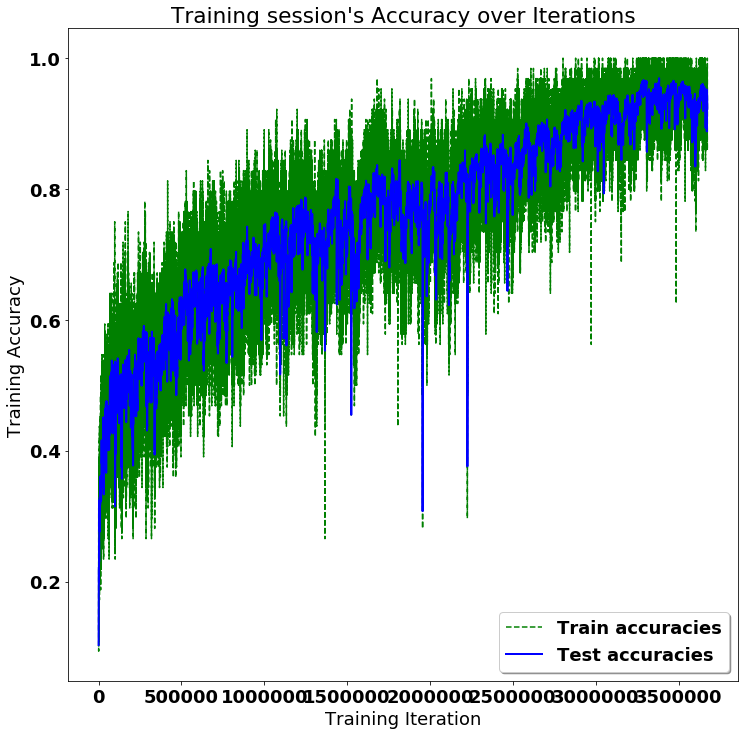

Testing Accuracy: 92.14046597480774%

Precision: 92.26838196872286%
Recall: 92.14046822742475%
f1_score: 92.1158047843318%

Confusion Matrix:
Created using test set of 1794 datapoints, normalised to % of each class in the test dataset


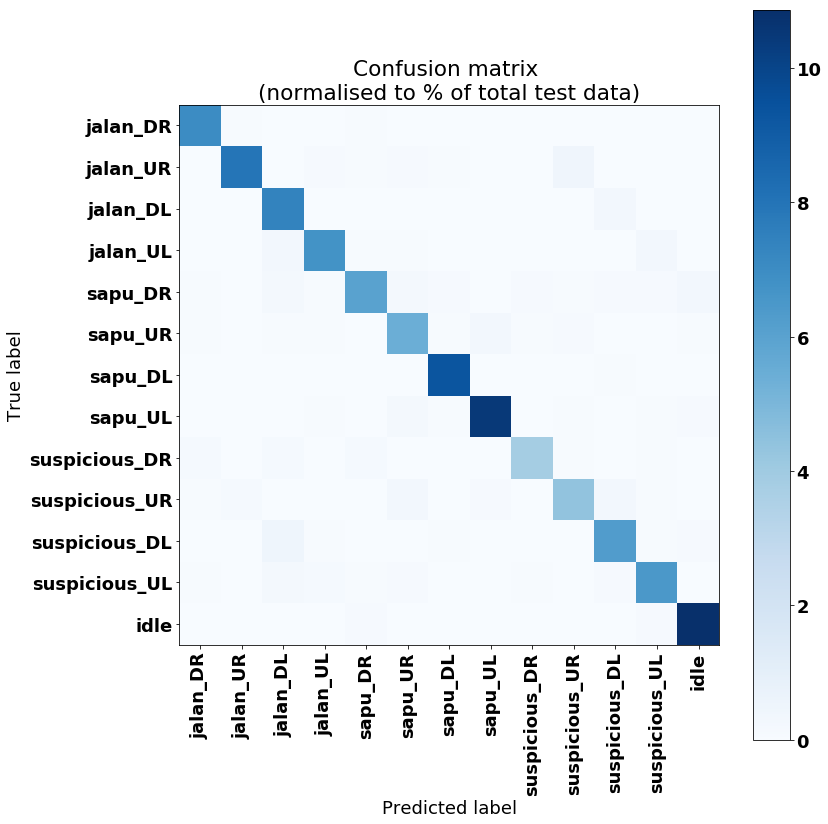

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.10312152, 0.1923077, 0.20568562, 0.22240803, 0.20011148, 0.2625418, 0.23076923, 0.2826087, 0.29598662, 0.2781494, 0.2826087, 0.32497212, 0.27647716, 0.29264215, 0.32943144, 0.3238573, 0.27982163, 0.33835006, 0.31772575, 0.32107022, 0.32943144, 0.33444816, 0.36120403, 0.3322185, 0.32664436, 0.32274246, 0.33556297, 0.35897437, 0.34336677, 0.32329988, 0.3522854, 0.35730213, 0.3439242, 0.36566332, 0.39576367, 0.41583055, 0.39632106, 0.3807135, 0.38517278, 0.38517278, 0.39018953, 0.38628763, 0.36343366, 0.3857302, 0.39409143, 0.37068003, 0.38294315, 0.39855072, 0.3779264, 0.39520624, 0.40802675, 0.38740245, 0.4057971, 0.42976588, 0.4509476, 0.4292085, 0.44091415, 0.42474917, 0.4013378, 0.35841694, 0.33333334, 0.3779264, 0.3846154, 0.3924192, 0.4264214, 0.39186177, 0.41638795, 0.39464882, 0.38795987, 0.41694537, 0.39855072, 0.42753622, 0.4292085, 0.43199554, 0.42697883, 0.43645486, 0.45875138, 0.46376812, 0.4542921, 0.4464883, 0.43645486, 0.44091415, 0.46376812, 0.43255296, 0.42865106, 0.

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
# !jupyter nbconvert --to markdown LSTM.ipynb
# !mv LSTM.md README.md

## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
